# Electric Motor Permanent Magnet Temperature Forecasting using LSTM

**Author:** Muhammad Ben Hamad  
**Date:** 2025-12-23  
**Framework:** TensorFlow / Keras  
**Problem:** Predict the permanent magnet (PM) temperature of an electric motor at a **future horizon of 80 steps / 40s** based on historical measurements **120 steps / 60s**.

**Dataset:** [Electric Motor Temperature Dataset on Kaggle](https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature)

**Deployment Target:** NEV (New Energy Vehicle) motor temperature monitoring and predictive control.

---

## Model Overview

* **Type:** LSTM-based Recurrent Neural Network (RNN)  
* **Input Shape:** `(lookback_window=120, features=18)`  
* **Output:** Scalar ΔPM temperature at the forecast horizon (direct prediction without iterative steps)

**Architecture:**

| Layer              | Output Shape       | Parameters |
| ------------------ | ----------------- | ---------- |
| Input              | `(None, 120, 18)` | 0          |
| LSTM (64 units)    | `(None, 120, 64)` | 21,248     |
| BatchNormalization | `(None, 120, 64)` | 256        |
| LSTM (64 units)    | `(None, 64)`      | 33,024     |
| BatchNormalization | `(None, 64)`      | 256        |
| Dense (16)         | `(None, 16)`      | 1,040      |
| Dense (8)          | `(None, 8)`       | 136        |
| Dense (1)          | `(None, 1)`       | 9          |

* **Total parameters:** 55,969  
* **Trainable parameters:** 55,713  
* **Non-trainable parameters:** 256  

---

## Input Features

The model uses **18 real-time electrical, mechanical, and thermal features** of the motor, including:

* Phase voltages (`u_d`, `u_q`)  
* Currents (`i_d`, `i_q`)  
* Motor speed (`motor_speed`)  
* Torque (`torque`)  
* PM and stator temperatures  
* Derived features: rolling averages, electrical power proxies, and thermal indicators  

---

## Training Setup

* **Loss function:** Mean Absolute Error (MAE)  
* **Optimizer:** Adam (learning rate tuned)  
* **Metrics monitored:** MAE, RMSE, R²  

**Hyperparameters:**

* Lookback window: 120 timesteps  
* Horizon: 80 timesteps (forecasting)  
* Batch size: 256  
* Learning rate: 0.001  

---

## Model Parameters & Test Performance

| Metric / Info                        | Value     |
| ------------------------------------ | --------- |
| Total parameters                     | 55,969    |
| Trainable parameters                 | 55,713    |
| Non-trainable parameters             | 256       |
| Approx. RAM usage for weights        | 0.21 MB   |
| Approx. disk size (saved model .h5)  | 0.25 MB   |
| MAE (Test)                           | 0.4350 °C |
| RMSE (Test)                          | 0.6506 °C |
| R² (Test)                            | 0.8071    |

> **Interpretation:**  
>
> * The model predicts PM temperature with an average error of ~0.44°C at an 80-step horizon.  
> * RMSE is ~0.65°C, indicating small deviations in long-term predictions.  
> * R² of 0.8071 indicates that ~81% of the variance is captured — excellent for long-term motor temperature forecasting.


In [1]:
# Core Data Science & ML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os
import warnings
from sklearn.cluster import KMeans

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, BatchNormalization, Activation, Add, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tqdm.keras import TqdmCallback

# System & Utilities
import time
import random
from datetime import datetime
import json

print("Imports complete. TF version:", tf.__version__)

Imports complete. TF version: 2.10.0


### Electric Motor PM Temperature Forecasting Configuration

> This CONFIG allows easy adjustments to temporal settings, model architecture, training parameters, and dataset handling for efficient experimentation.


In [43]:
CONFIG = {
    # ==================== PATHS ====================
    'CSV_PATH' : "measures_v2.csv",

    # ==================== TEMPORAL PARAMETERS ====================
    "TEMPORAL": {
        "SAMPLE_RATE_HZ": 2,       # Samples per second
        "LOOKBACK_SEC": 60,       # Lookback window in seconds
        "SEQ_LEN": 120,            # Sequence length for LSTM (matches lookback)
        
        "HORIZON_SEC": 40,         # Horizon in seconds
        "HORIZON_STEPS": 80,       # Forecast steps
    },

    # ==================== MODEL ARCHITECTURE ====================
    "MODEL": {
        "LSTM_LAYERS": [64, 64],      # Units in each LSTM layer
        "DENSE_LAYERS": [16, 8],    # Dense layers units
        "DROPOUT_RATES": [0.0, 0.0],   # No dropout 
        "ACTIVATION": "tanh",          # Activation function
    },

    # ==================== TRAINING PARAMETERS ====================
    "TRAINING": {
        "BATCH_SIZE": 256,
        "EPOCHS": 5,
        "LEARNING_RATE": {
            "LR": 0.001, 
        },            
        "MONITOR": "val_mae",
        "PATIENCE": 6,
        "LOSS": "mae",
        "METRICS": ["mae"],
        "RANDOM_STATE": 42,
    },

    # ==================== DATA HANDLING ====================
    "DATA": {
        "TARGET_COLUMN": "pm",
        "DROP_COLUMNS": ["profile_id"],
    }
}

In [3]:
def load_dataset(csv_path: str) -> pd.DataFrame:
    print(" Loading...")
    print("=" * 60)
    df = pd.read_csv(csv_path)
    print(f" Data Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    return df
df = load_dataset(CONFIG['CSV_PATH'])
df.head(5)

 Loading...
 Data Shape: 1330816 rows, 13 columns


u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197          17

### Driving Profile Statistical Analysis

> Generates clean, high-level metrics per operating profile **without altering the data**.

* Uses sampling rate to compute **profile duration** and derives thermal/mechanical insights (speed, torque, temperature).
* Adds power estimation using dq-axis electrical components.
* Results are **rounded summary statistics**, enabling quick anomaly detection and dataset quality assessment.
  → Foundation for profile clustering and identifying operational behavior patterns.


In [4]:
def analyze_profile_statistics(df):
    sample_rate = CONFIG['TEMPORAL']['SAMPLE_RATE_HZ']
    target = CONFIG['DATA']['TARGET_COLUMN']
    def profile_summary(group):
        n = len(group)
        return pd.Series({
            'profile_id'         : group.name,
            'n_samples'          : n,
            'duration_sec'       : n / sample_rate,
            'motor_speed_mean'   : group['motor_speed'].mean(),
           'motor_speed_std'    : group['motor_speed'].std(),
            'torque_mean'        : group['torque'].mean(),
            'torque_std'         : group['torque'].std(),
            'pm_mean'            : group[target].mean(),
            'pm_max'             : group[target].max(),
            'stator_winding_mean': group['stator_winding'].mean(),
            'stator_winding_max' : group['stator_winding'].max(),
            'coolant_mean'       : group['coolant'].mean(),
            'power_mean'         : (group['u_q'] * group['i_q'] + group['u_d'] * group['i_d']).mean(),
        })

    print("Computing profile statistics...")
    stats_df = df.groupby('profile_id').apply(profile_summary).reset_index(drop=True)
    stats_df = stats_df.round(3)

    print(f"{len(stats_df)} profiles analyzed")
    return stats_df

### Profile Feature Distribution Visualization

> Displays histogram-based distributions of key operational metrics (speed, torque, temperature, cooling, duration) across all profiles.


In [5]:
def visualize_profile_distributions(stats_df, ncols=3):
    features = [
        'motor_speed_mean', 'torque_mean', 'pm_mean',
        'stator_winding_mean', 'coolant_mean', 'duration_sec'
    ]

    nrows = (len(features) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
    axes = axes.flatten() if nrows > 1 else [axes] if ncols == 1 else axes

    for ax, feat in zip(axes, features):
        if feat not in stats_df.columns:
            ax.set_visible(False)
            continue
        data = stats_df[feat]
        ax.hist(data, bins=20, alpha=0.75, color='#3498db', edgecolor='black')
        mean_val = data.mean()
        std_val = data.std()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
        ax.axvline(mean_val + std_val, color='orange', linestyle=':', alpha=0.8)
        ax.axvline(mean_val - std_val, color='orange', linestyle=':', alpha=0.8)
        ax.set_title(feat.replace('_', ' ').title(), fontsize=12, pad=10)
        ax.set_ylabel('Profiles')
        ax.legend(fontsize=9)

    for j in range(len(features), len(axes)):
        axes[j].set_visible(False)

    plt.suptitle('Profile Feature Distributions', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### Profile Clustering (Operational Behavior Grouping)

> Applies **K-Means clustering** on selected statistical features to detect natural operating patterns across driving profiles.


In [6]:
def identify_profile_clusters(stats_df, n_clusters=4, random_state=42):
    features = ['motor_speed_mean', 'torque_mean', 'pm_mean', 'duration_sec']
    X = stats_df[features]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=20)
    stats_df['cluster'] = kmeans.fit_predict(X_scaled)

    print(f"\nFound {n_clusters} natural operating clusters:")
    for c in sorted(stats_df['cluster'].unique()):
        cluster = stats_df[stats_df['cluster'] == c]
        print(f"  Cluster {c} ({len(cluster)} profiles) → "
              f"Speed {cluster['motor_speed_mean'].mean():.0f} RPM | "
              f"Torque {cluster['torque_mean'].mean():.1f} Nm | "
              f"PM Temp {cluster['pm_mean'].mean():.1f}°C")

    return stats_df

### Stratified Dataset Split (Cluster-Aware)

> Generates a **train/validation/test profile split** while preserving cluster distribution to avoid dataset bias.

In [7]:
def suggest_stratified_split(stats_df, train_ratio=0.75, val_ratio=0.15):

    from collections import Counter

    total = len(stats_df)
    n_train = int(total * train_ratio)
    n_val = int(total * val_ratio)
    n_test = total - n_train - n_val

    split = {'train': [], 'val': [], 'test': []}

    for cluster in sorted(stats_df['cluster'].unique()):
        profiles = stats_df[stats_df['cluster'] == cluster]['profile_id'].tolist()
        np.random.shuffle(profiles)

        split['train'].extend(profiles[:int(len(profiles)*train_ratio)])
        split['val'].extend(profiles[int(len(profiles)*train_ratio):int(len(profiles)*(train_ratio+val_ratio))])
        split['test'].extend(profiles[int(len(profiles)*(train_ratio+val_ratio)):])

    print(f"\nSuggested stratified split:")
    print(f"  Train: {len(split['train'])} profiles")
    print(f"  Val:   {len(split['val'])} profiles")
    print(f"  Test:  {len(split['test'])} profiles")

    return split

### Profile Analysis Pipeline — Execution Overview

> Complete **data understanding stage**:


Computing profile statistics...
69 profiles analyzed


profile_id  n_samples  duration_sec  motor_speed_mean  motor_speed_std  \
0         2.0    19357.0        9678.5            100.00             0.03   
1         3.0    19248.0        9624.0            100.00             0.02   
2         4.0    33424.0       16712.0           2683.07          1920.80   
3         5.0    14788.0        7394.0            999.99             0.01   
4         6.0    40388.0       20194.0           3445.31          1954.06   
5         7.0    14651.0        7325.5            499.59            13.29   
6         8.0    18757.0        9378.5           1498.04            52.12   
7         9.0    20336.0       10168.0           2496.96            83.23   
8        10.0    15256.0        7628.0           1926.08          1476.81   
9        11.0     7887.0        3943.5           2115.52          1688.45   

   torque_mean  torque_std  pm_mean  pm_max  stator_winding_mean  \
0        79.15      100.30    32.76   45.99                51.11   
1        51.69       51.66    26.28   29.01                29.03   
2        32.84       49.21    49.76   99.40                46.01   
3        43.52       50.84    33.21   39.94                30.75   
4        15.35       65.17    69.23   93.51                70.84   
5        84.89       39.55    33.22   35.84                36.14   
6        53.49       51.44    36.94   44.28                35.15   
7        55.73       50.38    43.03   51.11                41.53   
8        -2.76       51.96    43.92   72.08                39.73   
9        47.81       60.37    46.23   57.11                49.37   

   stator_winding_max  coolant_mean  power_mean  
0              103.28         18.54     1268.80  
1               39.10         18.76      624.58  
2              113.38         18.63     7183.05  
3               43.40         18.80     3248.55  
4              121.03         29.02     7882.56  
5               39.96         18.70     3368.32  
6               45.99         18.59     5841.84  
7               54.52         18.67    10182.42  
8               93.68         18.73     1937.82  
9               74.47         18.55     9068.28

Visualizing operating regime diversity...


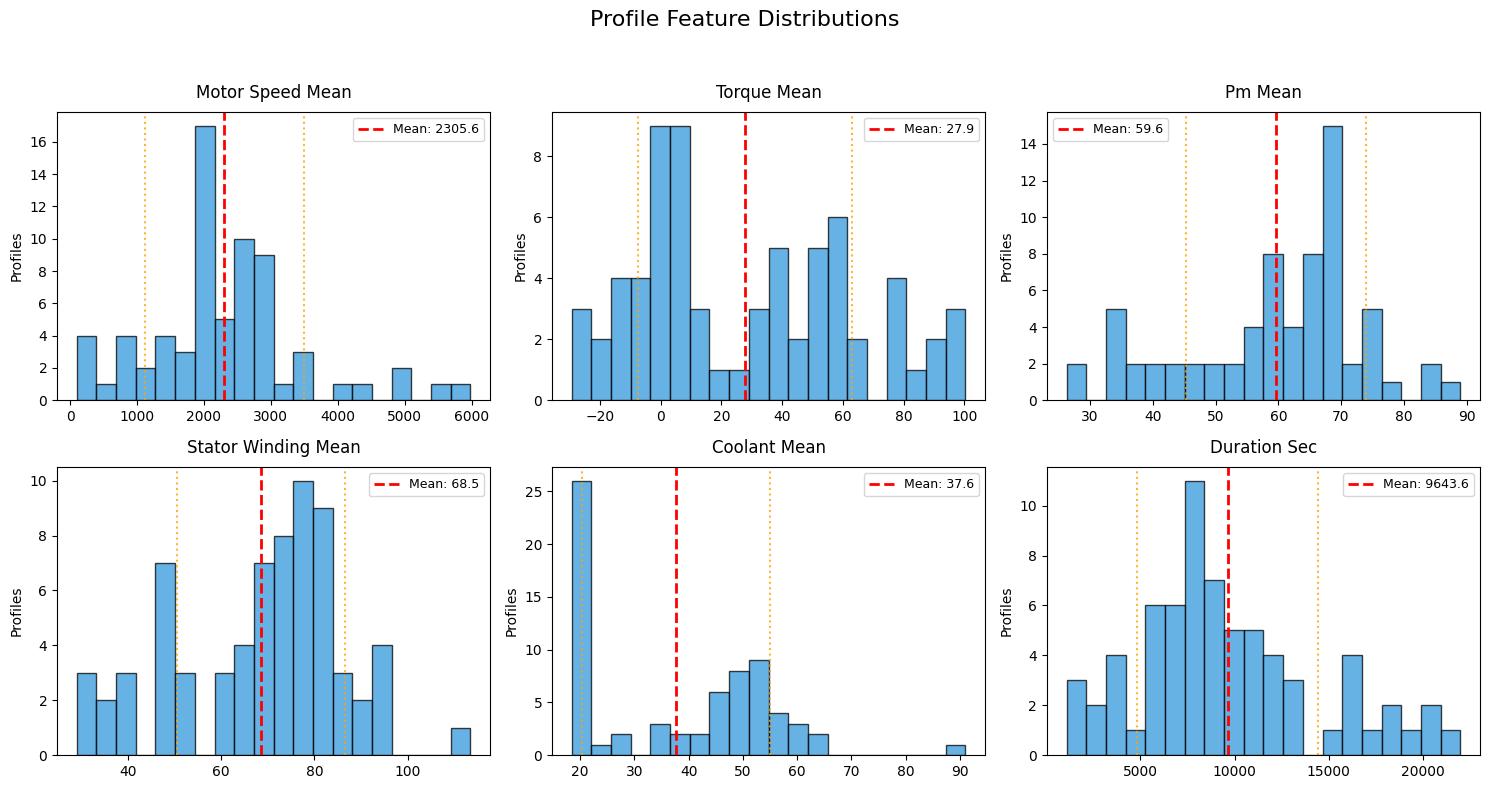


Found 5 natural operating clusters:
  Cluster 0 (10 profiles) → Speed 591 RPM | Torque 71.9 Nm | PM Temp 33.5°C
  Cluster 1 (23 profiles) → Speed 2273 RPM | Torque -1.7 Nm | PM Temp 64.3°C
  Cluster 2 (8 profiles) → Speed 4625 RPM | Torque 44.6 Nm | PM Temp 71.5°C
  Cluster 3 (10 profiles) → Speed 2267 RPM | Torque 66.3 Nm | PM Temp 55.0°C
  Cluster 4 (18 profiles) → Speed 2290 RPM | Torque 12.3 Nm | PM Temp 65.3°C


In [8]:
stats_df = analyze_profile_statistics(df)
display(stats_df.round(2).head(10))
print("Visualizing operating regime diversity...")
key_features = visualize_profile_distributions(stats_df)

stats_df = identify_profile_clusters(
    stats_df,
    n_clusters=5,
    random_state=CONFIG['DATA'].get('RANDOM_STATE', 42)
)

```show_profiles_by_cluster``` 
> Get all profile IDs in each cluster.

In [9]:
def show_profiles_by_cluster(stats_df, cluster_col='cluster', profile_col='profile_id'):
 
    if cluster_col not in stats_df.columns or profile_col not in stats_df.columns:
        print(f"Error: Required columns '{cluster_col}' or '{profile_col}' not found.")
        return
    
    clusters = stats_df[cluster_col].unique()
    print(f"Found {len(clusters)} clusters:\n")
    
    for cl in sorted(clusters):
        profiles = stats_df[stats_df[cluster_col] == cl][profile_col].tolist()
        print(f"Cluster {cl} ({len(profiles)} profiles) → {profiles}\n")
show_profiles_by_cluster(stats_df)

Found 5 clusters:

Cluster 0 (10 profiles) → [2.0, 3.0, 5.0, 7.0, 8.0, 13.0, 16.0, 18.0, 30.0, 36.0]

Cluster 1 (23 profiles) → [10.0, 46.0, 47.0, 49.0, 50.0, 51.0, 52.0, 54.0, 55.0, 57.0, 59.0, 60.0, 61.0, 63.0, 64.0, 67.0, 69.0, 71.0, 72.0, 73.0, 75.0, 78.0, 81.0]

Cluster 2 (8 profiles) → [15.0, 17.0, 19.0, 21.0, 23.0, 24.0, 26.0, 31.0]

Cluster 3 (10 profiles) → [9.0, 11.0, 12.0, 14.0, 29.0, 32.0, 41.0, 42.0, 43.0, 45.0]

Cluster 4 (18 profiles) → [4.0, 6.0, 20.0, 27.0, 44.0, 48.0, 53.0, 56.0, 58.0, 62.0, 65.0, 66.0, 68.0, 70.0, 74.0, 76.0, 79.0, 80.0]



## Adding Physically-Informed Rolling Features to PMSM Dataset

```
add_pmsm_rolling_features(df: pd.DataFrame, dt: float = 0.5, windows_sec=(10, 60)):
```
This function `add_pmsm_rolling_features` enhances the raw PMSM (Permanent Magnet Synchronous Motor) dataset by **computing physically meaningful features** that capture electrical, mechanical, and thermal trends over time. These features help the LSTM model understand the motor's dynamics more effectively.

### Key Steps:

1. **Electrical Power Proxy (`P_proxy`)**
   - Calculated as:  
     \[
     P\_proxy = u_d \cdot i_d + u_q \cdot i_q
     \]  
   - Represents the instantaneous electrical power (loss-related) delivered to the motor.

2. **Exponential Moving Averages (EMAs)**
   - Compute rolling averages over multiple time windows (`windows_sec`) for:
     - Electrical power (`P_ema_{sec}s`)
     - Motor speed (`speed_ema_{sec}s`)
     - Torque (`torque_ema_{sec}s`)
   - Windows are converted from seconds to sample spans using the dataset's timestep `dt`.

3. **Profile-Aware Grouping**
   - Rolling computations are **grouped by `profile_id`** to avoid leakage across different motor operating profiles.
   - A fix is applied to ensure **alignment with the original DataFrame** after group operations (`reset_index(level=0, drop=True)`).

### Arguments

- `df` : `pd.DataFrame`  
  The input PMSM dataset containing raw electrical, mechanical, and thermal measurements.
- `dt` : `float`, default `0.5`  
  Sample interval in seconds.
- `windows_sec` : tuple, default `(10, 60)`  
  Time windows (in seconds) over which to compute EMAs.

### Returns

- `pd.DataFrame`  
  A copy of the original dataset with new columns for power proxy and rolling features:
  - `P_proxy`
  - `P_ema_10s`, `P_ema_60s`
  - `speed_ema_10s`, `speed_ema_60s`
  - `torque_ema_10s`, `torque_ema_60s`

> These features provide context about energy accumulation, mechanical behavior, and cooling trends over multiple time scales, improving the LSTM’s ability to forecast PM temperature.


In [10]:
def add_pmsm_rolling_features(df: pd.DataFrame, dt: float = 0.5, windows_sec=(10, 60)):
    df = df.copy()

    # --- 1. Electrical power proxy (loss-related)
    df['P_proxy'] = df['u_d'] * df['i_d'] + df['u_q'] * df['i_q']

    # --- 2. Rolling windows (convert seconds → samples)
    spans = {sec: int(sec / dt) for sec in windows_sec}

    for sec, span in spans.items():
        # Energy accumulation
        df[f'P_ema_{sec}s'] = (
            df.groupby('profile_id')['P_proxy']
              .apply(lambda x: x.ewm(span=span, adjust=False).mean())
              .reset_index(level=0, drop=True)   
        )

        # Mechanical / cooling context
        df[f'speed_ema_{sec}s'] = (
            df.groupby('profile_id')['motor_speed']
              .apply(lambda x: x.ewm(span=span, adjust=False).mean())
              .reset_index(level=0, drop=True)
        )

        df[f'torque_ema_{sec}s'] = (
            df.groupby('profile_id')['torque']
              .apply(lambda x: x.ewm(span=span, adjust=False).mean())
              .reset_index(level=0, drop=True)
        )

    return df

In [11]:
df = add_pmsm_rolling_features(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 20 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
 13  P_proxy         1330816 non-null  float64
 14  P_ema_10s       1330816 non-null  float64
 15  speed_ema_10s   1330816 non-null  float64
 16  torque_ema_10s  1330816 non-null  fl

### `create_train_val_test_splits_final()`

**Purpose:**  
Generate final train, validation, and test splits for the motor dataset **based on profile IDs** while ensuring:
- Balanced representation across operating clusters.
- Separation of high, medium, and low motor speeds or PM temperature ranges.
- No data leakage between train, validation, and test sets.

**Methodology:**  
1. Profiles are first grouped into clusters (`all_profiles`) based on operating characteristics.
2. Specific profiles are pre-selected for:
   - **Validation (`val_selection`)**: representative of medium/high motor speeds and PM ranges.
   - **Test (`test_selection`)**: capturing low, medium, and high extremes for robust evaluation.
3. Remaining profiles in each cluster are assigned to **training**.
4. Final lists (`train_profiles`, `val_profiles`, `test_profiles`) are returned with **assertions to prevent leakage**.

**Outputs:**  
- `train_profiles` — list of profile IDs for training.  
- `val_profiles` — list of profile IDs for validation.  
- `test_profiles` — list of profile IDs for testing.  

**Prints:**  
- Number of profiles in each split and total count.  
- Ensures no overlap between splits.


In [12]:
def create_train_val_test_splits_final():
    all_profiles = {
        0: [2,3,5,7,8,13,16,18,30,36],                 # 10
        1: [10,46,47,49,50,51,52,54,55,57,59,60,61,
            63,64,67,69,71,72,73,75,78,81],           # 24
        2: [15,17,19,21,23,24,26,31],                  # 8
        3: [9,11,12,14,29,32,41,42,43,45],             # 10
        4: [4,6,20,27,44,48,53,56,58,62,65,66,68,70,
            74,76,79,80]                              # 17
    }
    val_selection = {
        0: [13,30],               # medium motor_speed
        1: [63,64,67],         # mix of low/high motor_speed
        2: [17],               # high PM range
        3: [43],             # medium motor_speed
        4: [74]       # high motor_speed & PM
    }
    test_selection = {
        0: [36,3],            # low motor_speed
        1: [71,75],         # medium/high motor_speed
        2: [31],            # medium/high PM range
        3: [45],            # medium motor_speed
        4: [44]            # high motor_speed
    }
    train_profiles = []
    val_profiles = []
    test_profiles = []

    for c in all_profiles:
        val_profiles.extend(val_selection.get(c, []))
        test_profiles.extend(test_selection.get(c, []))
        remaining = [p for p in all_profiles[c]
                     if p not in val_selection.get(c, [])
                     and p not in test_selection.get(c, [])]
        train_profiles.extend(remaining)

    print("Train:", len(train_profiles))
    print("Val:", len(val_profiles))
    print("Test:", len(test_profiles))
    print("Total:", len(train_profiles)+len(val_profiles)+len(test_profiles))

    # Leakage check
    assert len(set(train_profiles) & set(val_profiles)) == 0
    assert len(set(train_profiles) & set(test_profiles)) == 0
    assert len(set(val_profiles) & set(test_profiles)) == 0

    return train_profiles, val_profiles, test_profiles

In [13]:
train_profiles , val_profiles , test_profiles = create_train_val_test_splits_final()

Train: 54
Val: 8
Test: 7
Total: 69


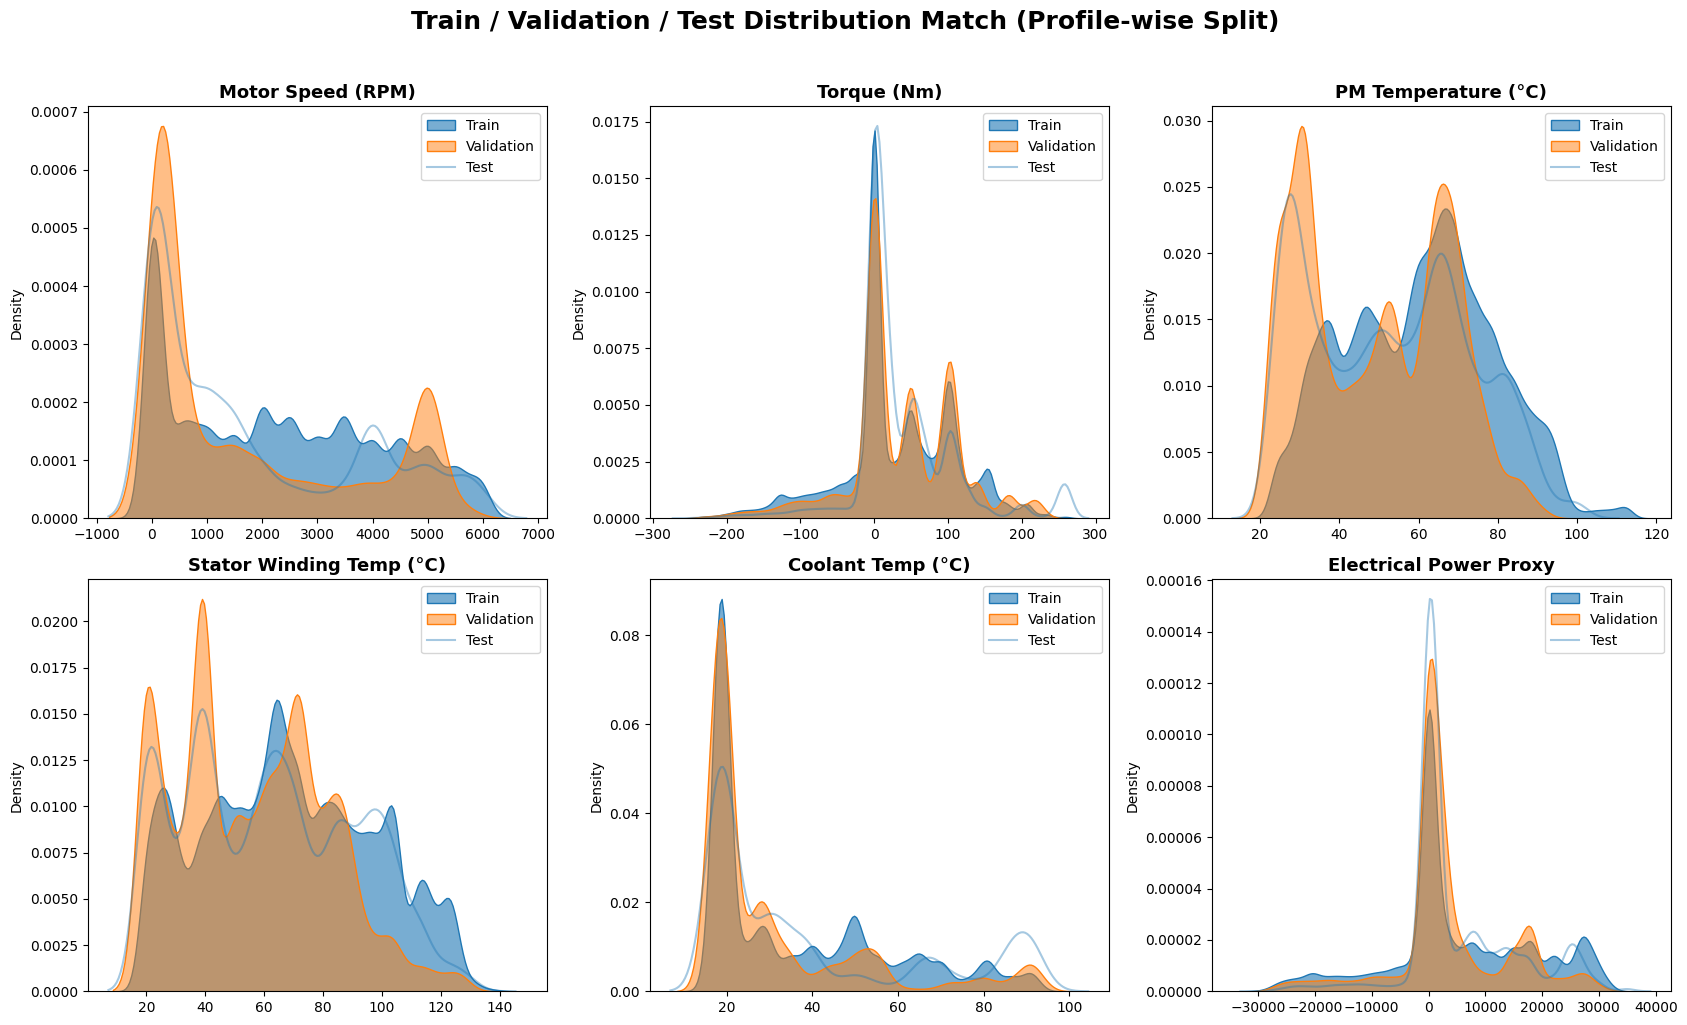


DATASET SPLIT SUMMARY
Train        | Rows:  1059771 ( 79.6%) | Profiles:  54 ( 78.3%)
Validation   | Rows:   141990 ( 10.7%) | Profiles:   8 ( 11.6%)
Test         | Rows:   129055 (  9.7%) | Profiles:   7 ( 10.1%)

DISTRIBUTION SIMILARITY (MEAN COMPARISON)
Motor Speed (RPM)              | Train:  2319.55 | Val:  1702.31 | Δ 26.61%
Torque (Nm)                    | Train:    29.77 | Val:    35.42 | Δ 19.00%
PM Temperature (°C)            | Train:    60.38 | Val:    49.30 | Δ 18.35%
Stator Winding Temp (°C)       | Train:    68.27 | Val:    55.90 | Δ 18.12%
Coolant Temp (°C)              | Train:    36.58 | Val:    31.02 | Δ 15.22%
Electrical Power Proxy         | Train:  5291.55 | Val:  3447.83 | Δ 34.84%


In [14]:
def plot_train_val_distribution(
    df,
    train_ids,
    val_ids,
    test_ids=None,
    sample_frac=0.15,
    title_suffix=""
):
    """
    Visual + numerical proof that Train / Val / Test
    are statistically representative at the SAMPLE level
    while being split at the PROFILE level.
    """

    # --------------------------------------------------
    # 1. Label splits
    # --------------------------------------------------
    data = df.copy()
    data["split"] = "Train"
    data.loc[data["profile_id"].isin(val_ids), "split"] = "Validation"

    if test_ids is not None:
        data.loc[data["profile_id"].isin(test_ids), "split"] = "Test"

    # --------------------------------------------------
    # 2. Features that ACTUALLY exist in your df
    # --------------------------------------------------
    features = [
        "motor_speed",
        "torque",
        "pm",
        "stator_winding",
        "coolant",
        "P_proxy"
    ]

    nice_names = {
        "motor_speed": "Motor Speed (RPM)",
        "torque": "Torque (Nm)",
        "pm": "PM Temperature (°C)",
        "stator_winding": "Stator Winding Temp (°C)",
        "coolant": "Coolant Temp (°C)",
        "P_proxy": "Electrical Power Proxy"
    }

    # --------------------------------------------------
    # 3. Downsample for plotting (VERY important at 1.3M rows)
    # --------------------------------------------------
    plot_df = (
        data.groupby("split", group_keys=False)
            .apply(lambda x: x.sample(frac=sample_frac, random_state=42))
    )

    # --------------------------------------------------
    # 4. KDE plots
    # --------------------------------------------------
    fig, axes = plt.subplots(2, 3, figsize=(17, 10))
    axes = axes.flatten()

    for i, col in enumerate(features):
        ax = axes[i]

        sns.kdeplot(
            data=plot_df[plot_df["split"] == "Train"],
            x=col, label="Train", fill=True, alpha=0.6, ax=ax
        )

        sns.kdeplot(
            data=plot_df[plot_df["split"] == "Validation"],
            x=col, label="Validation", fill=True, alpha=0.5, ax=ax
        )

        if test_ids is not None:
            sns.kdeplot(
                data=plot_df[plot_df["split"] == "Test"],
                x=col, label="Test", alpha=0.4, ax=ax
            )

        ax.set_title(nice_names[col], fontsize=13, fontweight="bold")
        ax.set_xlabel("")
        ax.legend()

    plt.suptitle(
        f"Train / Validation / Test Distribution Match {title_suffix}",
        fontsize=18, fontweight="bold", y=1.02
    )
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------
    # 5. Dataset size report (THIS IS CRITICAL)
    # --------------------------------------------------
    print("\n" + "=" * 80)
    print("DATASET SPLIT SUMMARY")
    print("=" * 80)

    total_rows = len(data)
    total_profiles = data["profile_id"].nunique()

    for split in ["Train", "Validation", "Test"]:
        if split not in data["split"].values:
            continue

        rows = (data["split"] == split).sum()
        profiles = data.loc[data["split"] == split, "profile_id"].nunique()

        print(
            f"{split:12} | "
            f"Rows: {rows:8d} ({rows / total_rows * 100:5.1f}%) | "
            f"Profiles: {profiles:3d} ({profiles / total_profiles * 100:5.1f}%)"
        )

    print("=" * 80)

    # --------------------------------------------------
    # 6. Numerical similarity check (means)
    # --------------------------------------------------
    print("\nDISTRIBUTION SIMILARITY (MEAN COMPARISON)")
    print("=" * 80)

    for col in features:
        train_mean = data.loc[data["split"] == "Train", col].mean()
        val_mean = data.loc[data["split"] == "Validation", col].mean()

        diff = abs(train_mean - val_mean) / abs(train_mean) * 100

        print(
            f"{nice_names[col]:30} | "
            f"Train: {train_mean:8.2f} | "
            f"Val: {val_mean:8.2f} | "
            f"Δ {diff:5.2f}%"
        )

    print("=" * 80)

plot_train_val_distribution(
    df,
    train_ids=train_profiles,
    val_ids=val_profiles,
    test_ids=test_profiles,
    title_suffix="(Profile-wise Split)"
)


In [15]:
# =============================================================================
# FINAL CLEAN  VISUALIZATION PIPELINE — PER SPLIT
# =============================================================================
from typing import List

def setup_plot_style():
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (16, 10)
    plt.rcParams['font.size'] = 11
    sns.set_palette("deep")

setup_plot_style()

# ———————————————————————— STATS PER PROFILE (once) ————————————————————————
def compute_stats_per_profile(df: pd.DataFrame) -> dict:
    stats = {}
    for pid in df['profile_id'].unique():
        data = df[df['profile_id'] == pid]
        stats[int(pid)] = {
            'length': len(data),
            'pm_range': data['pm'].max() - data['pm'].min(),
            'pm_mean': data['pm'].mean(),
            'duration_sec': len(data) / 2.0  # 2 Hz
        }
    return stats

stats_per_profile = compute_stats_per_profile(df)

# ———————————————————————— MAIN PLOTTING FUNCTION (ONE PER SPLIT) ————————————————————————
def plot_split_time_series(
    df: pd.DataFrame,
    profiles: List[int],
    split_name: str,
    color: str,
    n_samples: int = 3
):

    if len(profiles) == 0:
        print(f"No profiles in {split_name} split.")
        return

    np.random.seed(42)
    selected = np.random.choice(profiles, size=min(n_samples, len(profiles)), replace=False)

    print(f"\nPLOTTING {split_name.upper()} SPLIT SAMPLES ({len(selected)} profiles)")
    print("=" * 70)

    features = [
        ('pm',            'PM Temperature [°C]',           'Target: Permanent Magnet Temperature'),
        ('motor_speed',   'Motor Speed [RPM]',             'Mechanical Load Indicator'),
        ('i_q',           'Quadrature Current i_q [A]',    'Torque-Producing Current'),
        ('u_d',           'Direct Voltage u_d [V]',        'Field Control Voltage'),
        ('coolant',       'Coolant Temperature [°C]',      'Cooling System State')
    ]

    for profile_id in selected:
        data = df[df['profile_id'] == profile_id].reset_index(drop=True)
        if len(data) < 300:
            continue

        # Take middle portion to avoid startup transients
        start = len(data) // 3
        sample = data.iloc[start:start + 600]
        time_sec = np.arange(len(sample)) * 0.5

        fig, axes = plt.subplots(len(features), 1, figsize=(16, 12))
        fig.suptitle(
            f"{split_name.upper()} SPLIT – Profile {int(profile_id)}\n"
            f"Duration: {stats_per_profile[int(profile_id)]['duration_sec']:.0f}s | "
            f"PM Range: {stats_per_profile[int(profile_id)]['pm_range']:.1f}°C | "
            f"Mean PM: {stats_per_profile[int(profile_id)]['pm_mean']:.1f}°C",
            fontsize=18, fontweight='bold', color=color, y=0.96
        )

        for idx, (col, label, desc) in enumerate(features):
            ax = axes[idx]
            y = sample[col]
            ax.plot(time_sec, y, color='#e74c3c', linewidth=2.2, alpha=0.9)
            mean_val = y.mean()
            std_val = y.std()

            ax.axhline(mean_val, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
            ax.fill_between(time_sec, mean_val - std_val, mean_val + std_val,
                            color='red', alpha=0.15)

            ax.set_ylabel(label, fontweight='bold', fontsize=12)
            ax.set_title(desc, fontsize=10, color='gray', pad=8)
            ax.grid(True, alpha=0.3, linestyle=':')
            ax.margins(x=0)

            # Stats box
            stats_text = f"Mean: {mean_val:.2f}\n±1σ: ±{std_val:.2f}"
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
                    verticalalignment='top', bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

        axes[-1].set_xlabel('Time [seconds]', fontsize=13, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()

        print(f"✓ Plotted Profile {int(profile_id)} — {split_name} split")

    print("=" * 70)


PLOTTING TRAIN SPLIT SAMPLES (3 profiles)


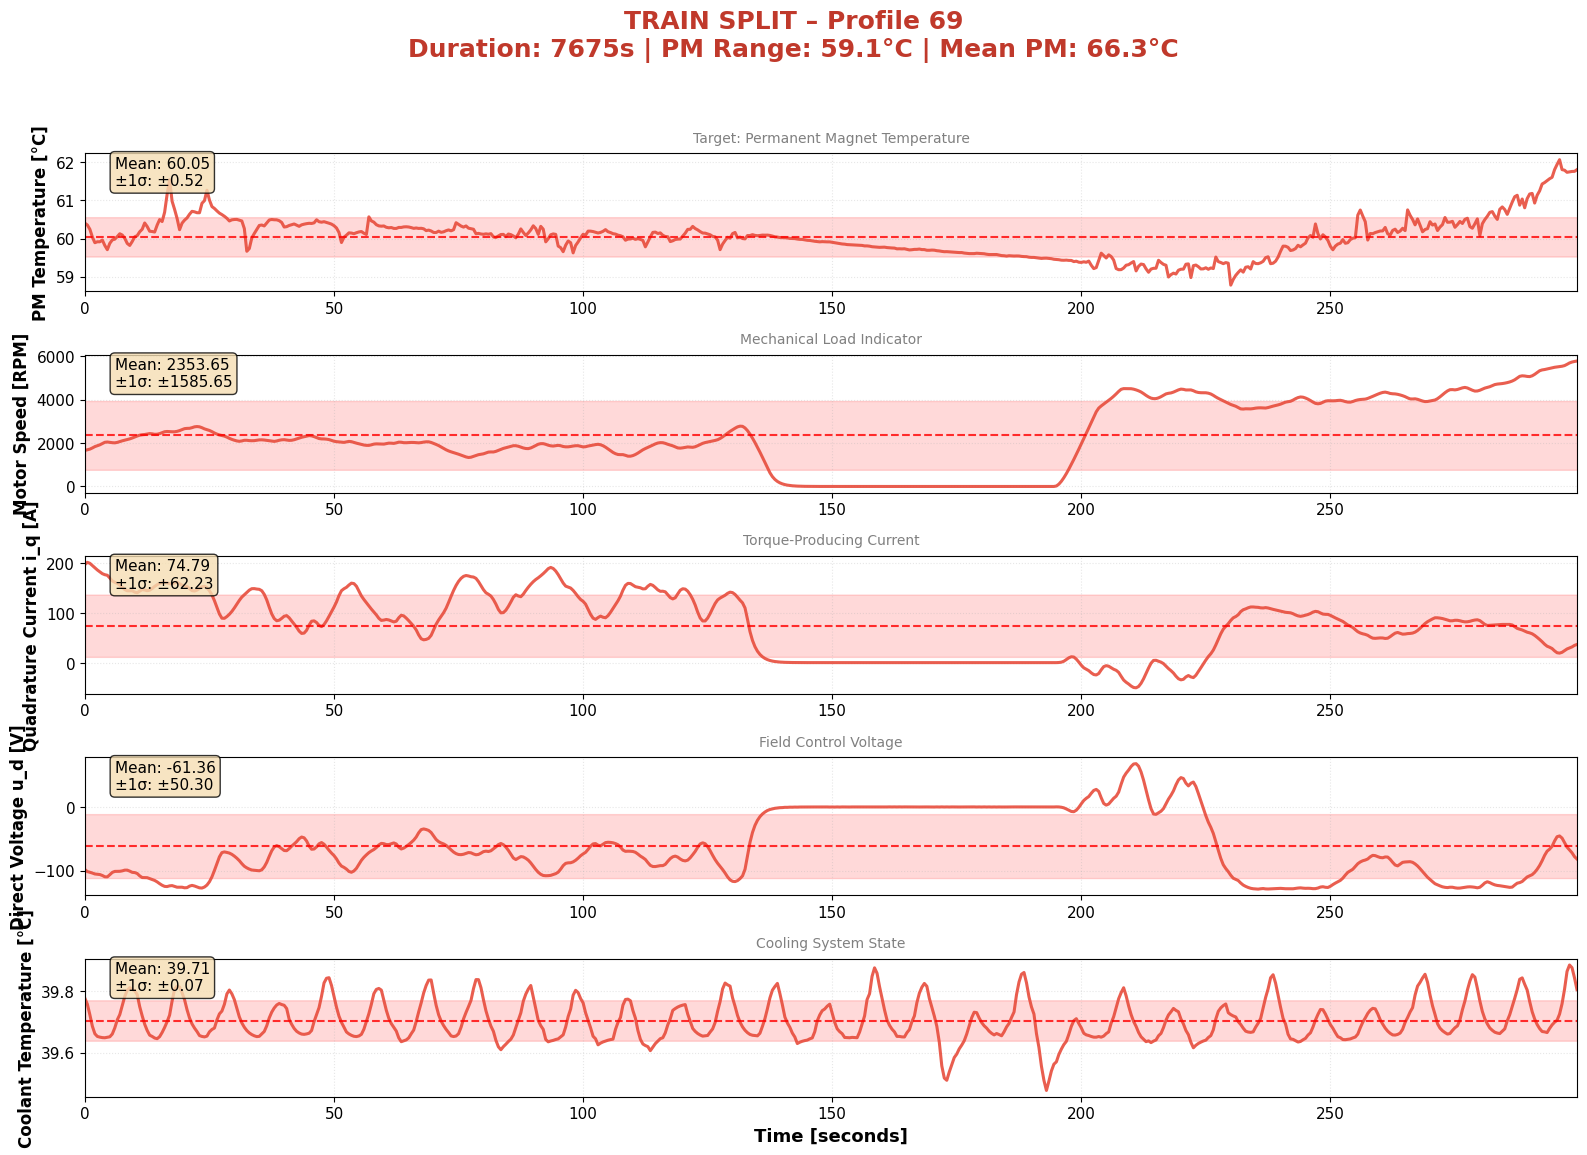

✓ Plotted Profile 69 — Train split


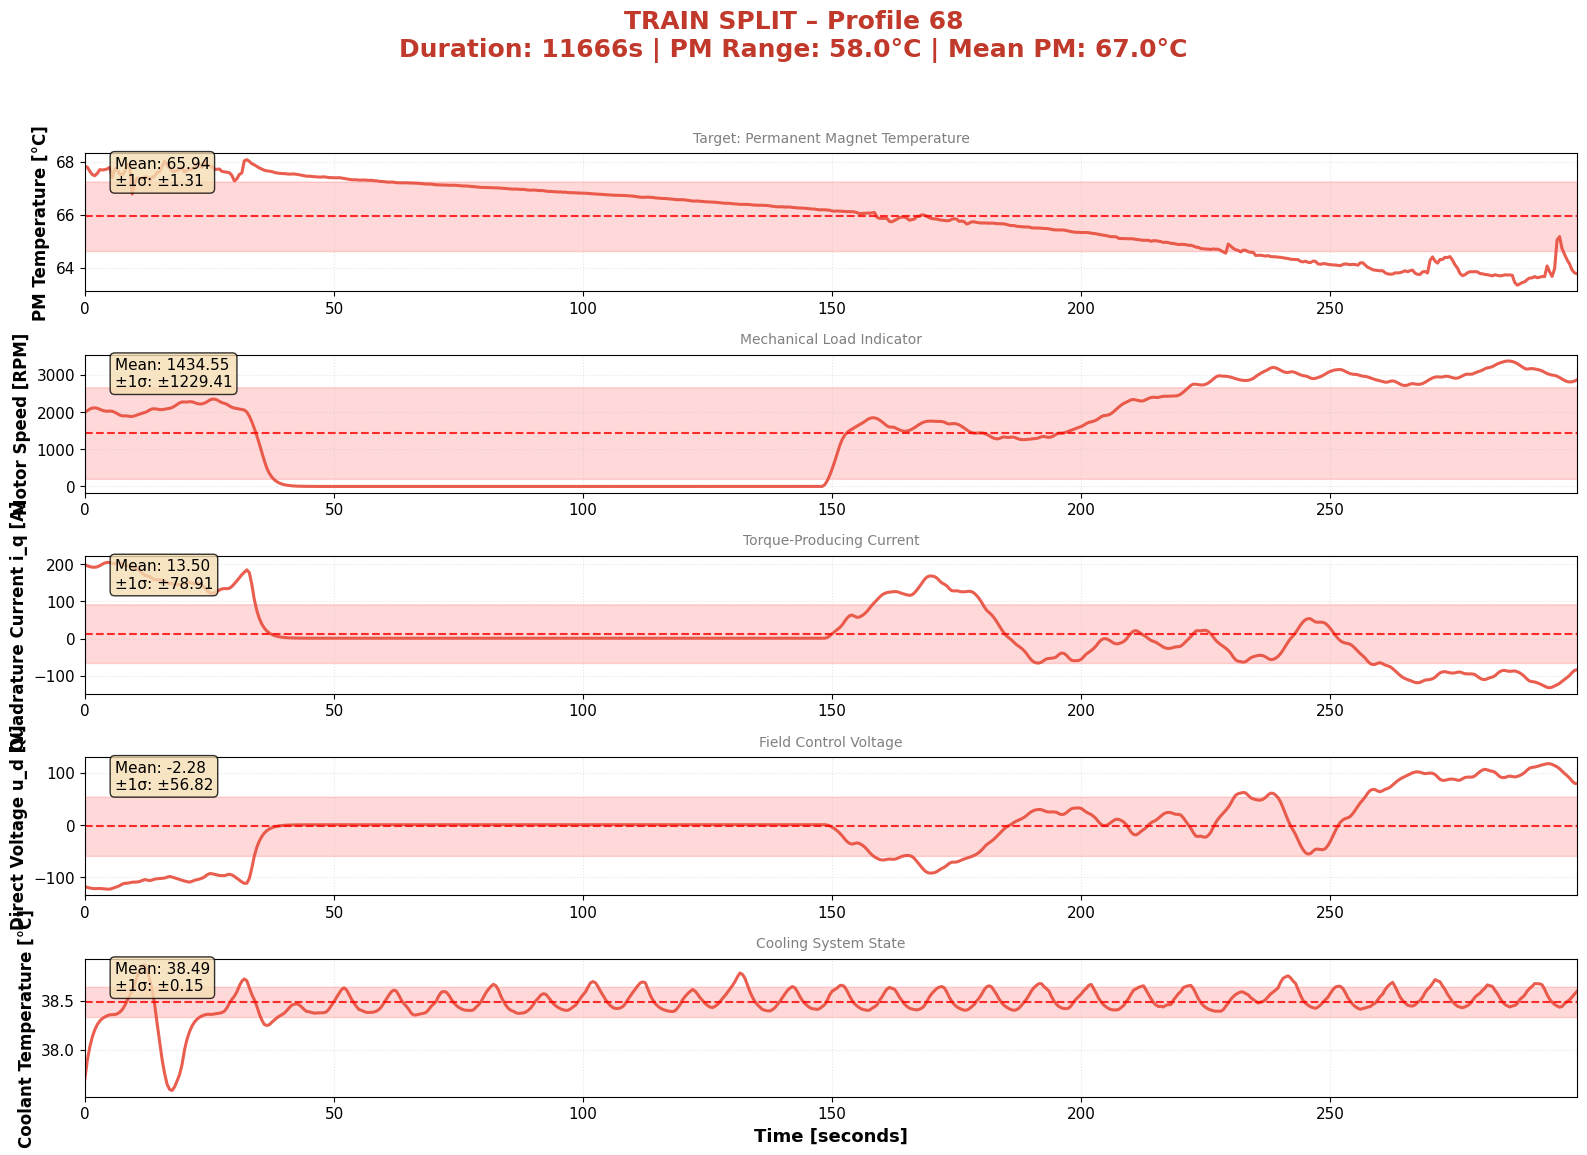

✓ Plotted Profile 68 — Train split


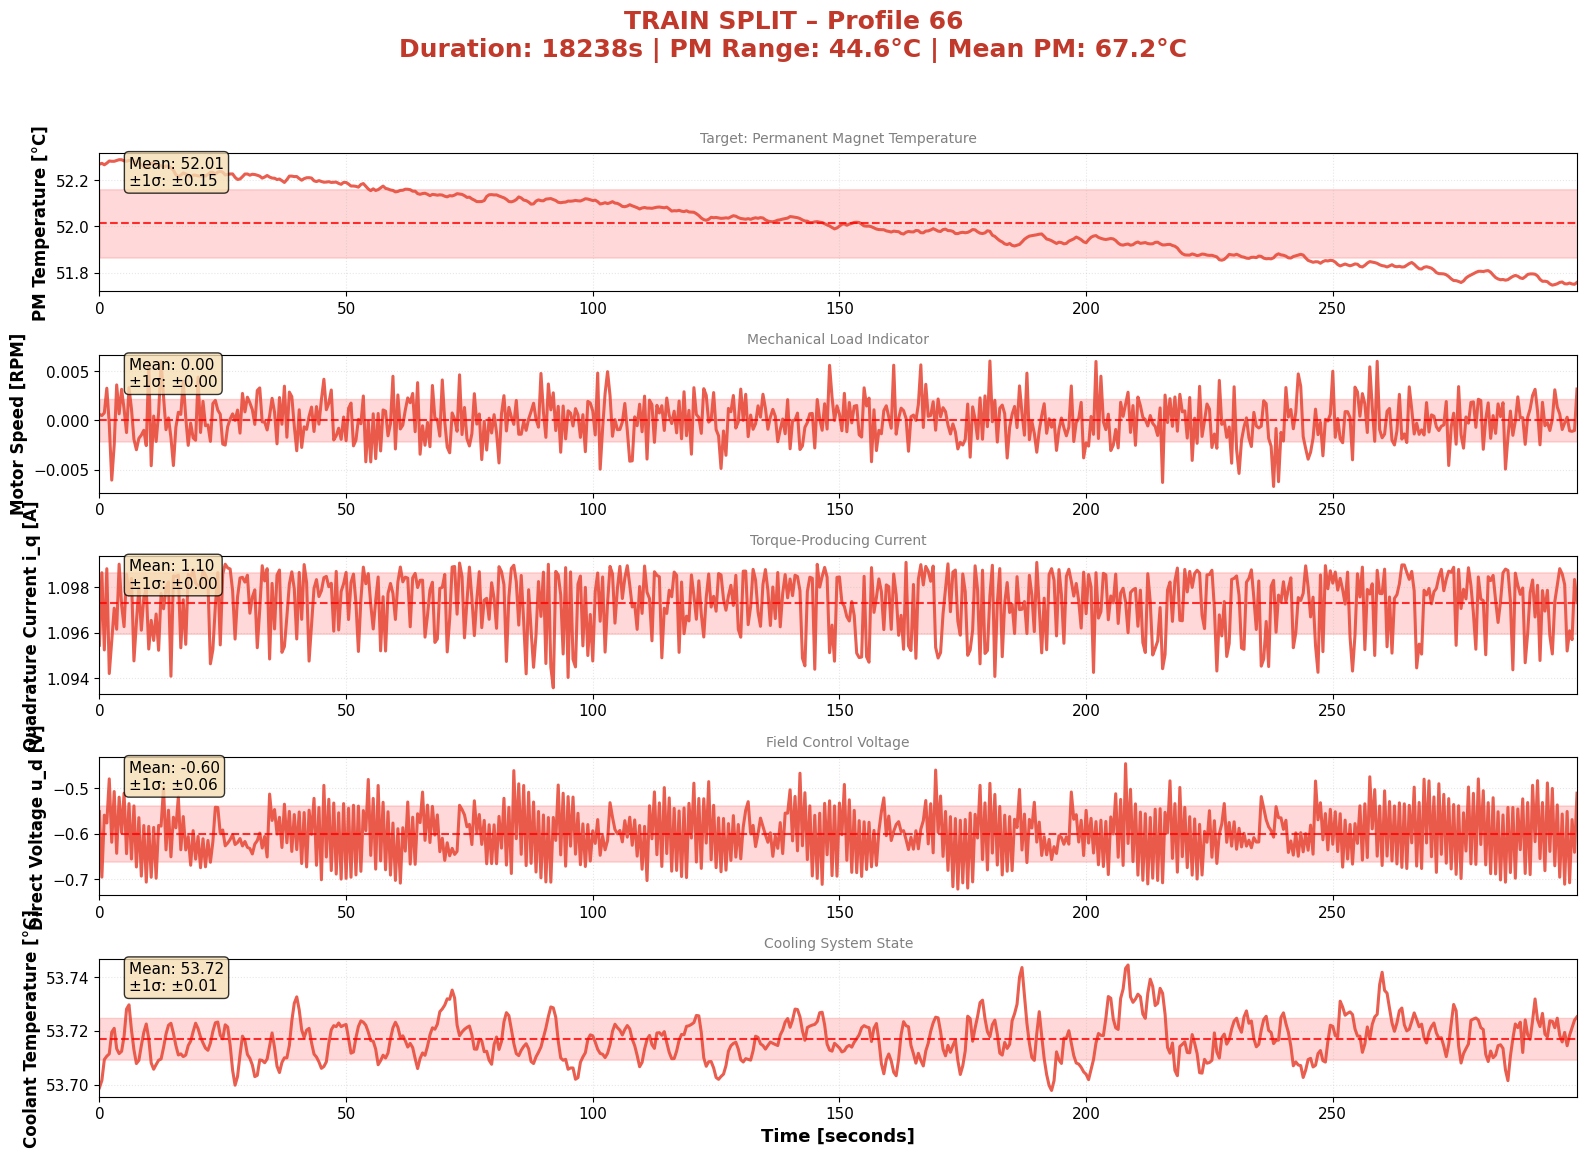

✓ Plotted Profile 66 — Train split


In [16]:
plot_split_time_series(df, train_profiles, "Train", color="#c0392b", n_samples=3)


PLOTTING VALIDATION SPLIT SAMPLES (3 profiles)


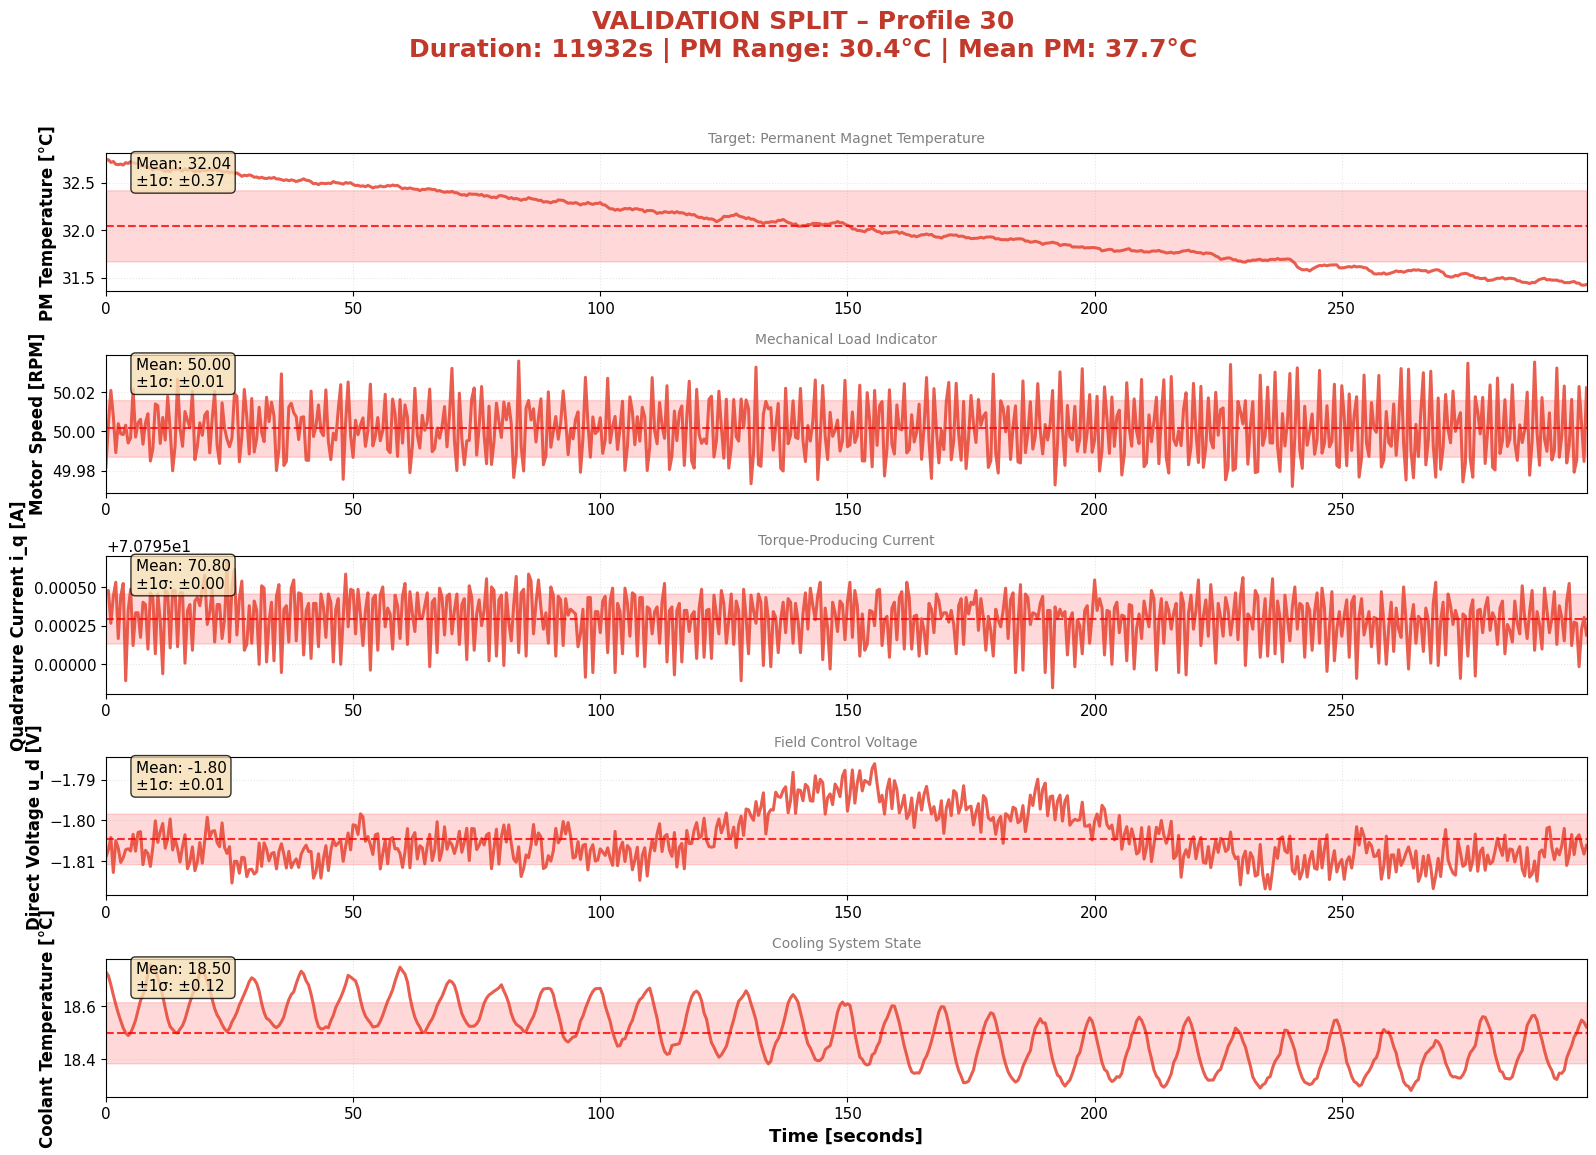

✓ Plotted Profile 30 — Validation split


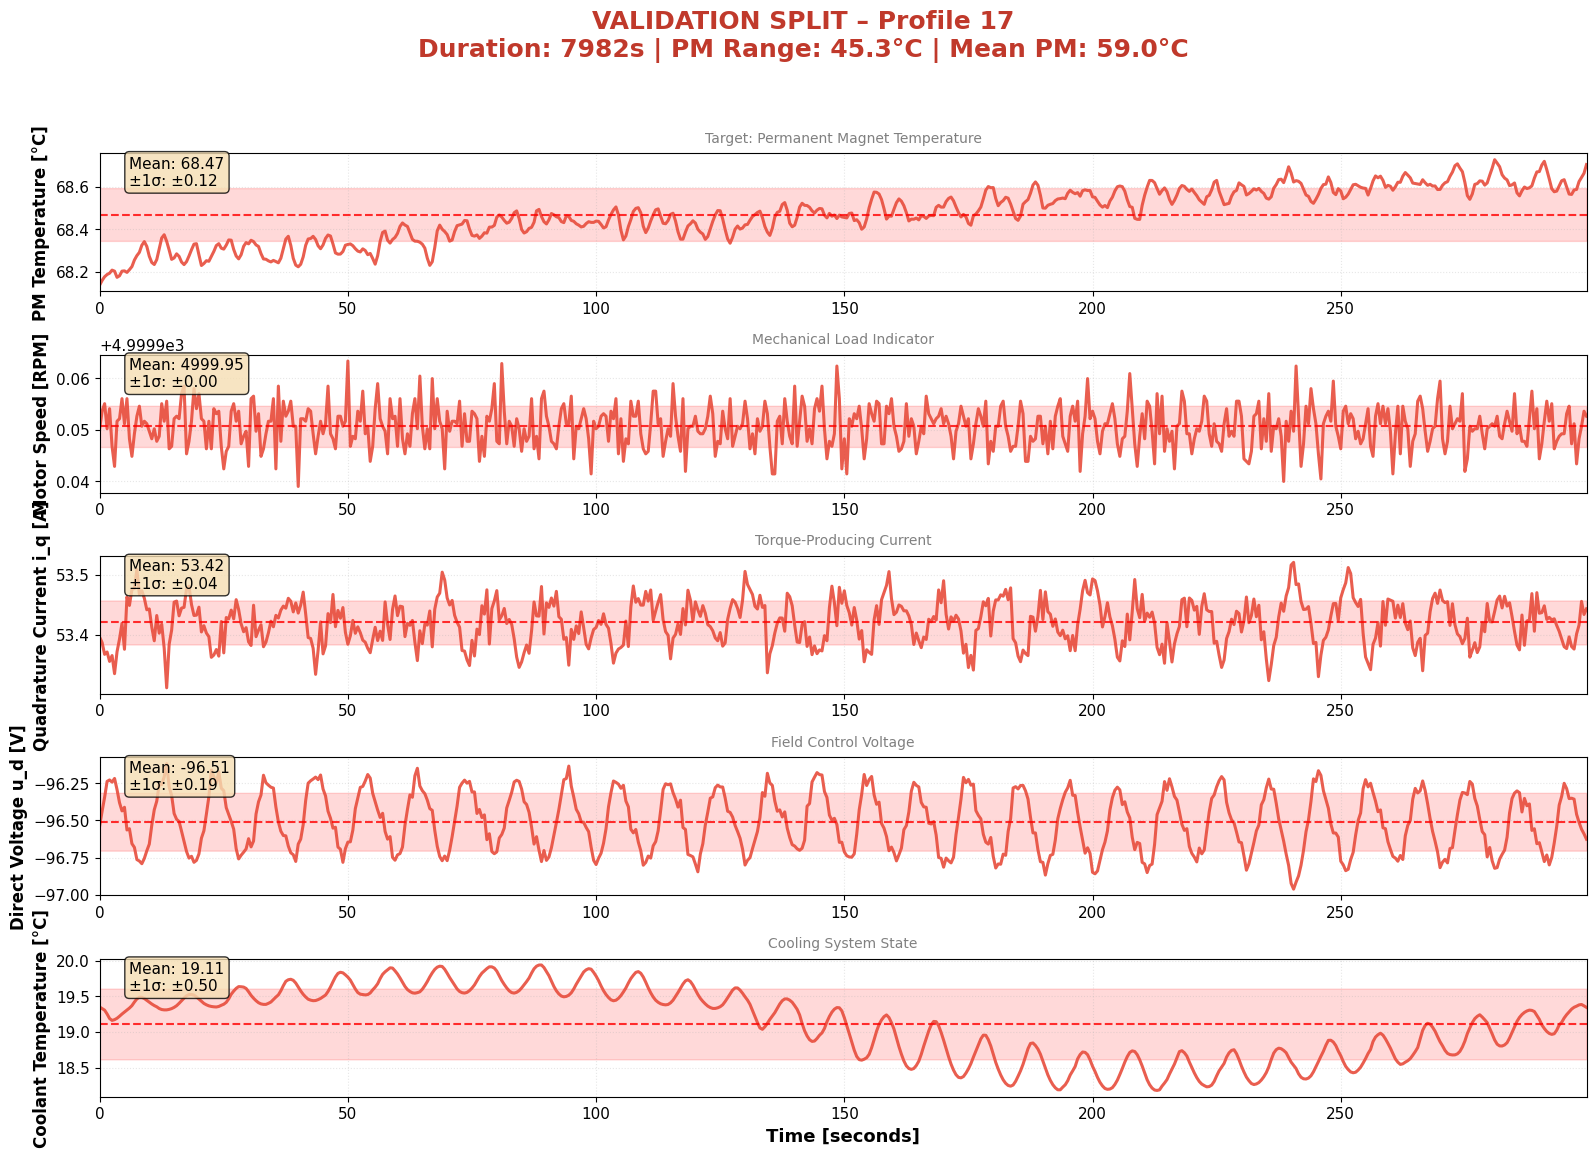

✓ Plotted Profile 17 — Validation split


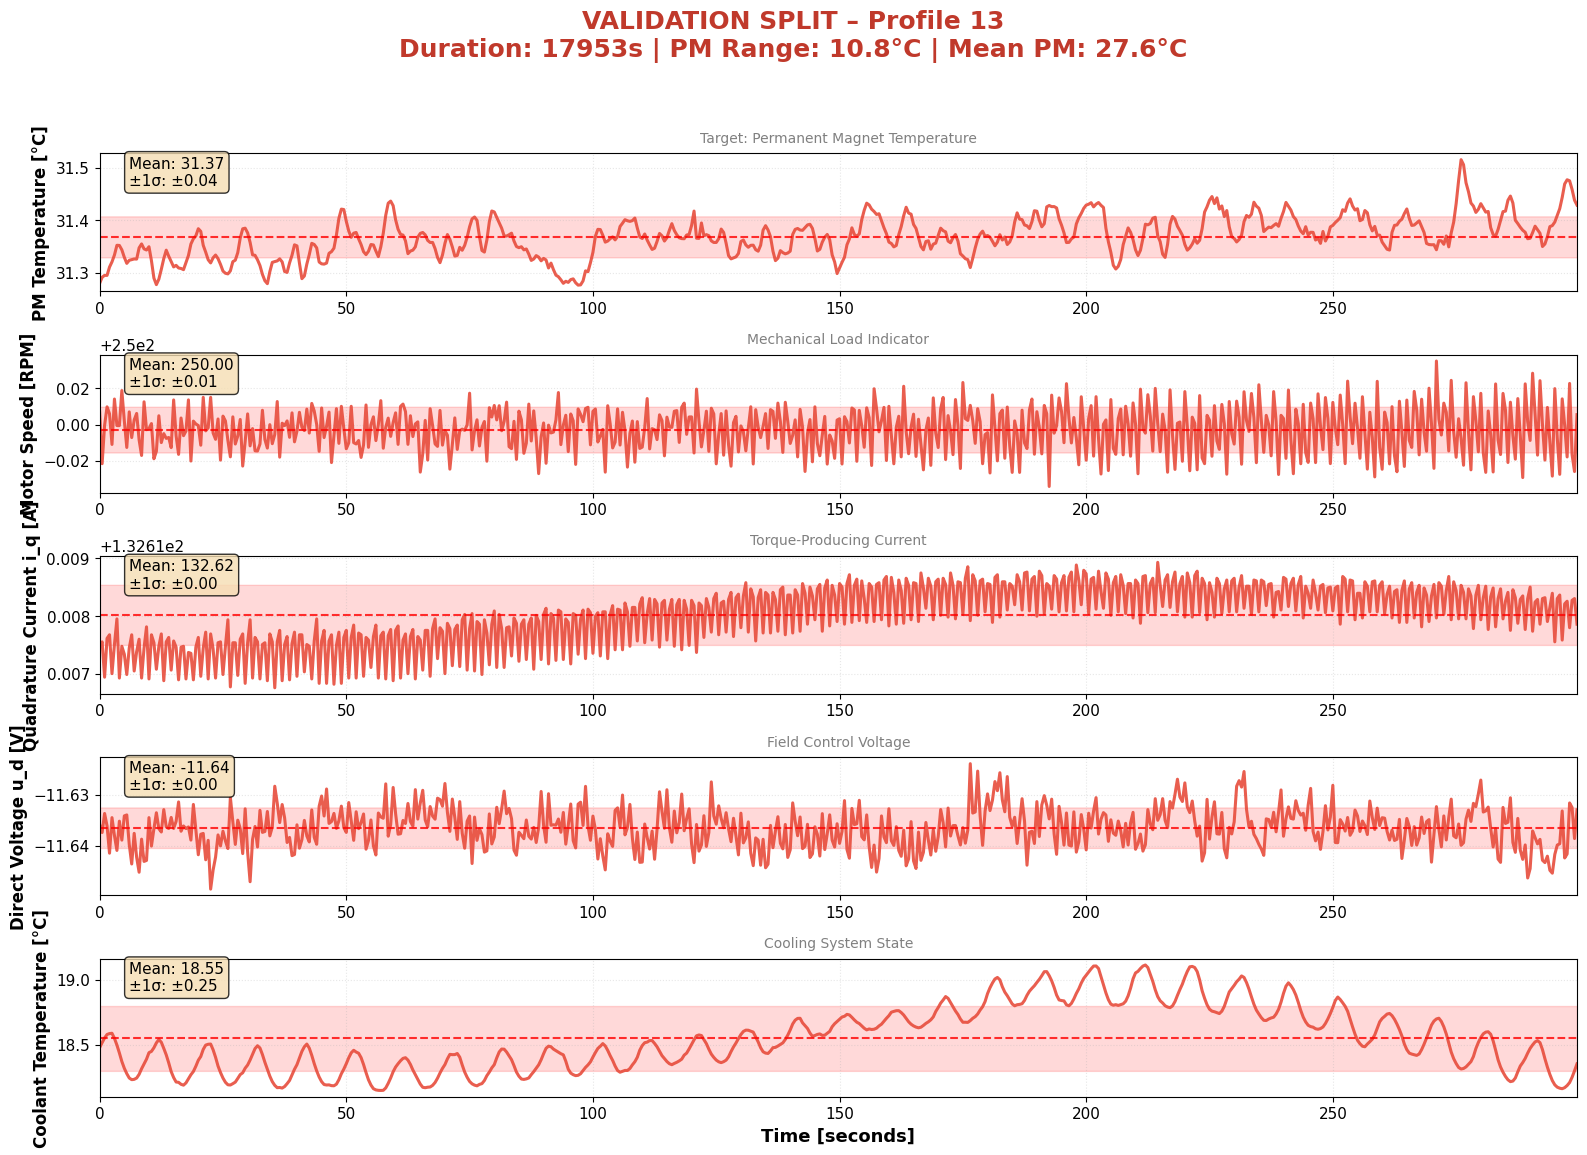

✓ Plotted Profile 13 — Validation split


In [17]:
plot_split_time_series(df, val_profiles, "Validation", color="#c0392b", n_samples=3)


PLOTTING TEST SPLIT SAMPLES (3 profiles)


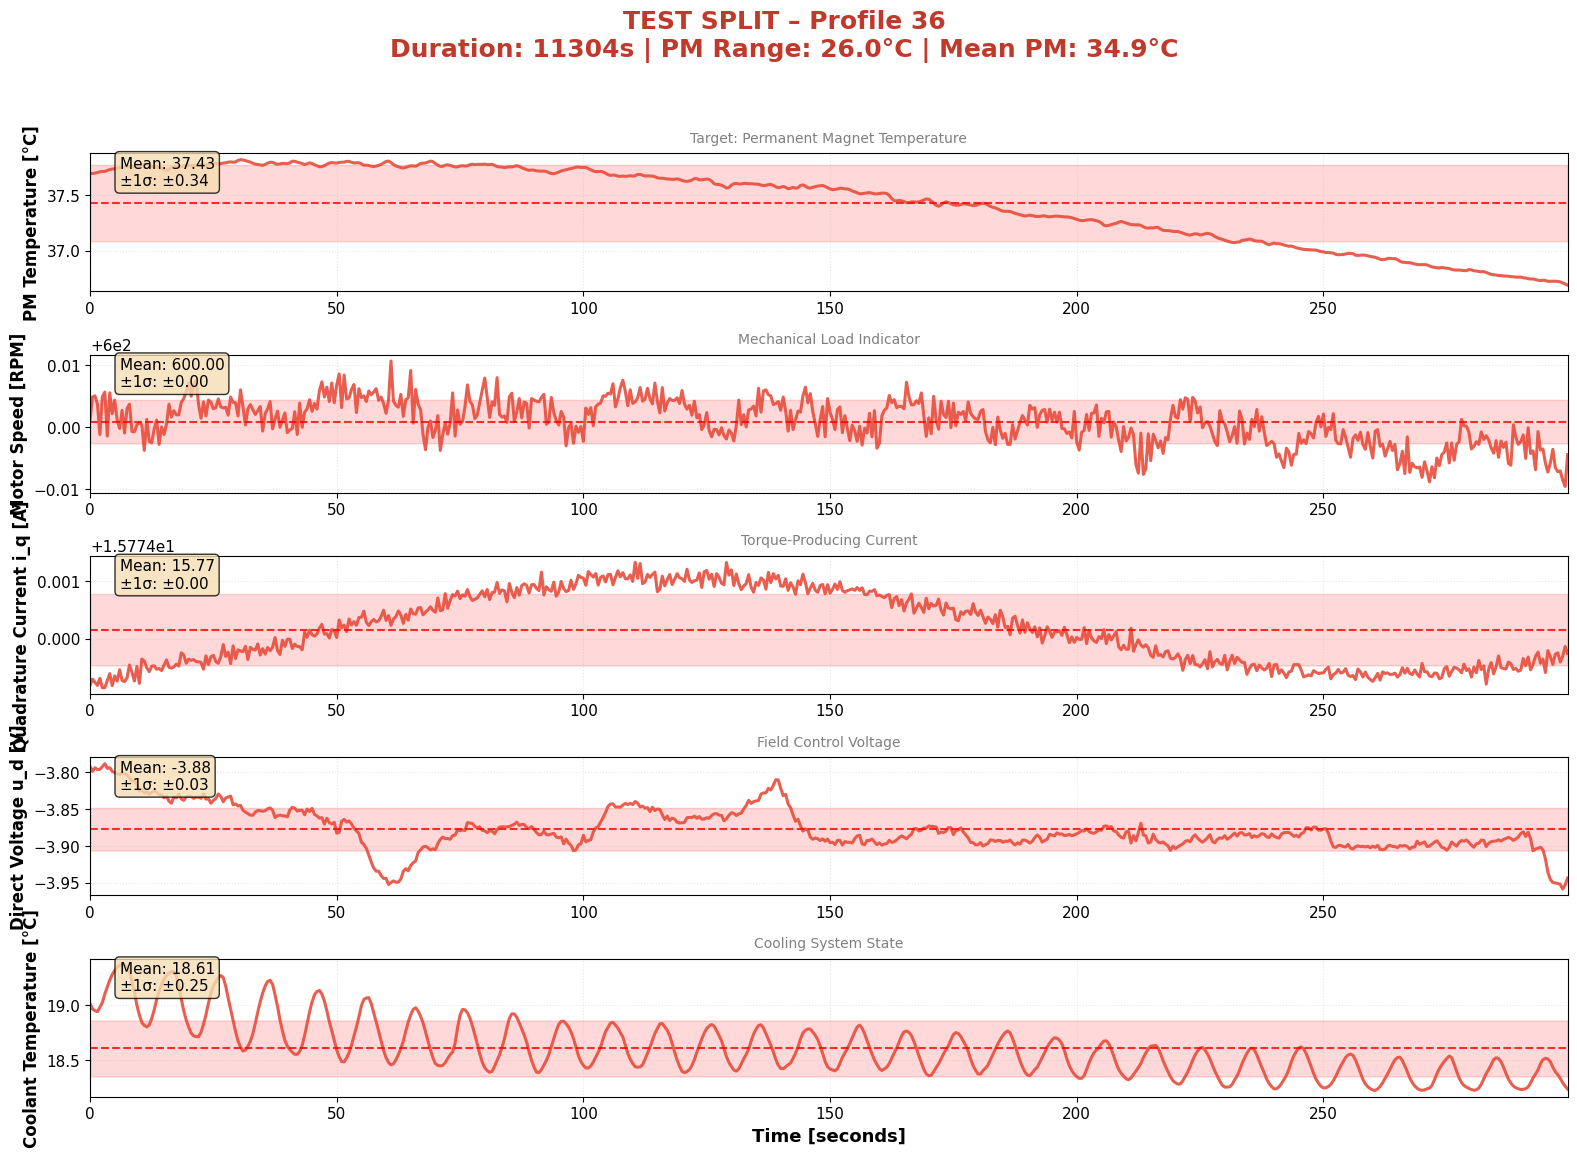

✓ Plotted Profile 36 — Test split


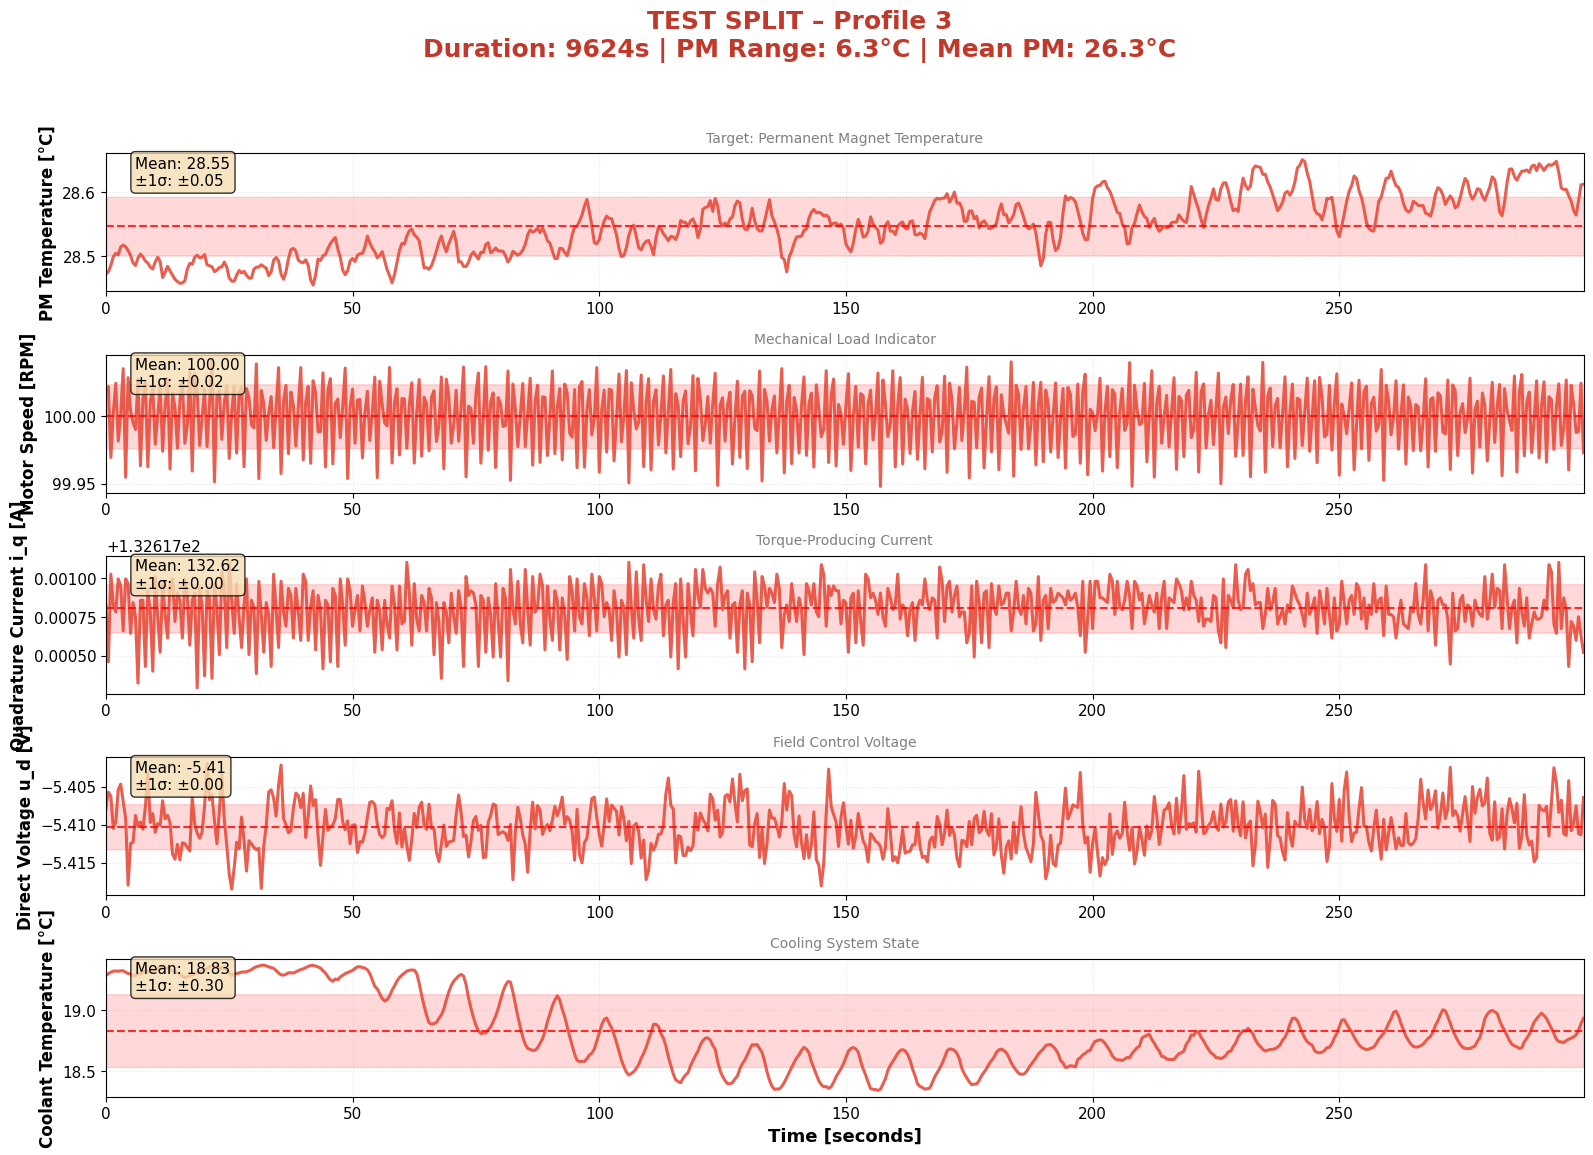

✓ Plotted Profile 3 — Test split


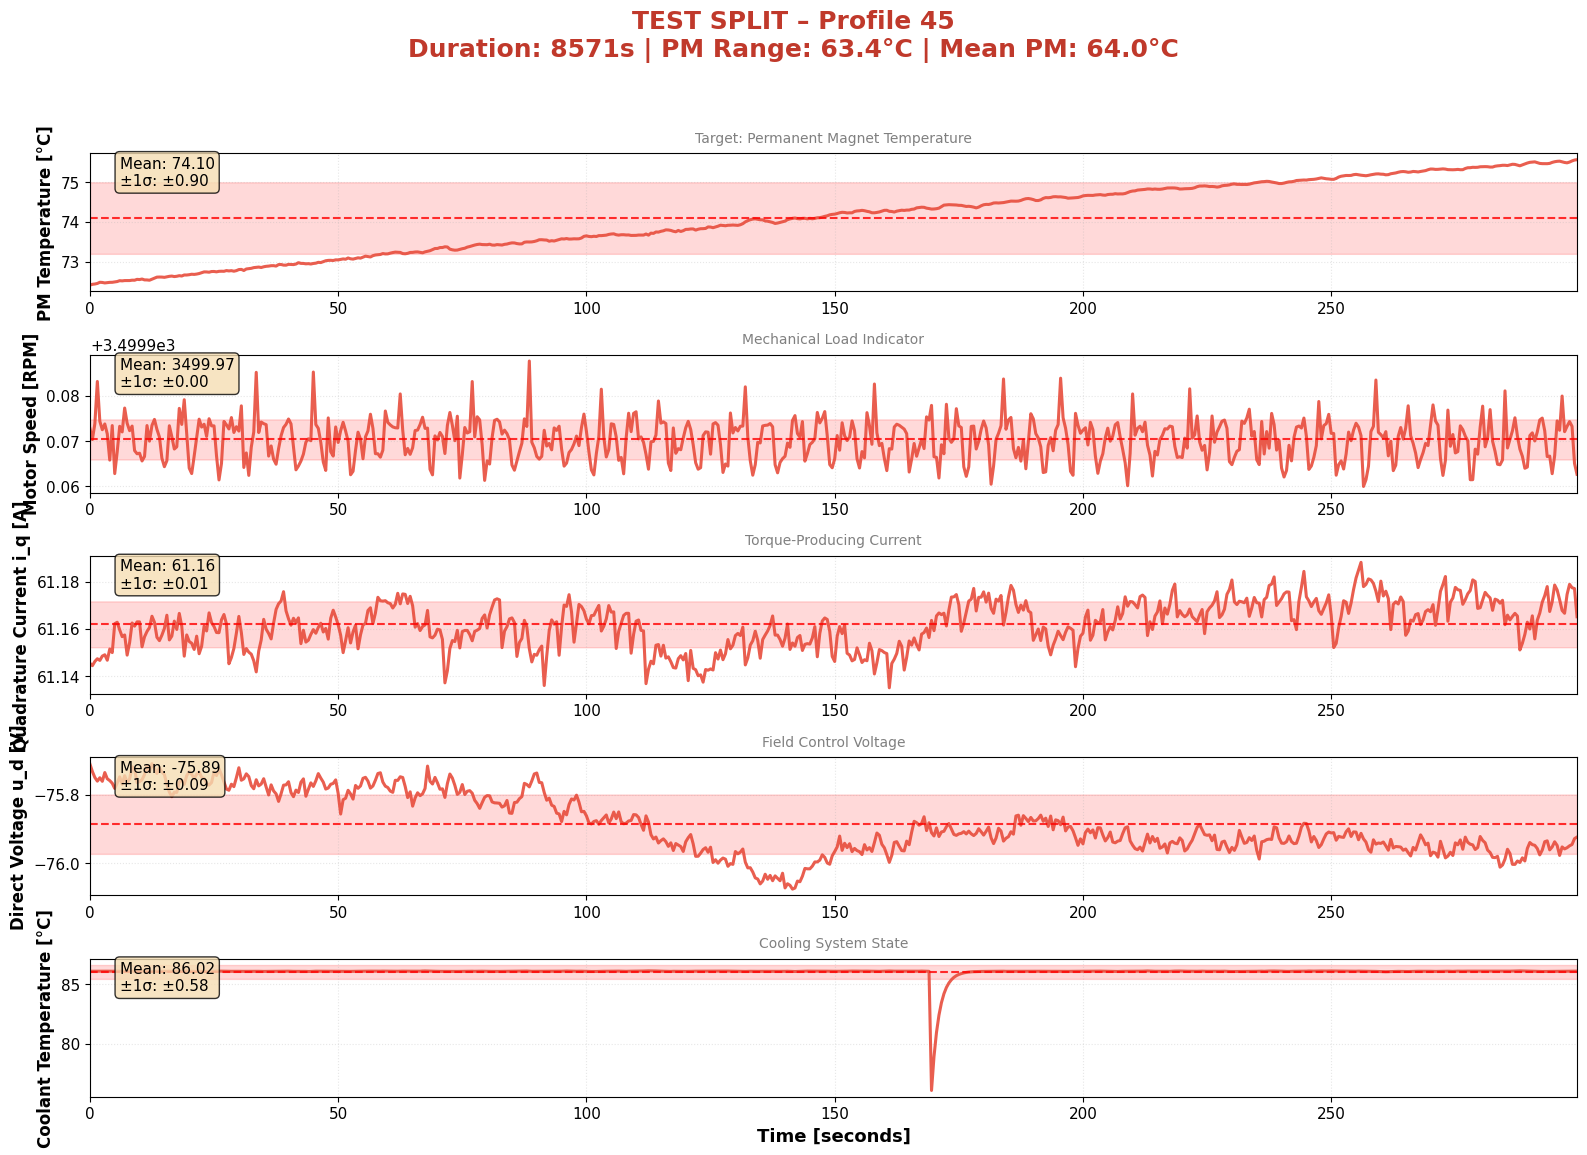

✓ Plotted Profile 45 — Test split


In [18]:
plot_split_time_series(df, test_profiles, "Test", color="#c0392b", n_samples=3)

## Dataset Split Analysis & Representativeness Assessment

### 1. Split Size and Coverage

The dataset contains **1,330,816 samples** distributed across **69 operating profiles**.  
The profile-wise split results in the following composition:

- **Training set**
  - 1,059,771 samples (**79.6% of total data**)
  - 54 profiles (**78.3% of all profiles**)

- **Validation set**
  - 141,990 samples (**10.7% of total data**)
  - 8 profiles (**11.6% of all profiles**)

- **Test set**
  - 129,055 samples (**9.7% of total data**)
  - 7 profiles (**10.1% of all profiles**)

**well-balanced at the profile level**, with validation and test sets each covering approximately **10% of both samples and operating profiles**, which is appropriate for sequence forecasting tasks with strong temporal correlations.

### 2. Distribution Similarity (Mean-Level Comparison)

A comparison of mean values between the **training** and **validation** sets reveals noticeable but structured differences:

| Feature | Train Mean | Validation Mean | Relative Difference |
|-------|-----------:|----------------:|--------------------:|
| Motor Speed (RPM) | 2319.55 | 1702.31 | 26.61% |
| Torque (Nm) | 29.77 | 35.42 | 19.00% |
| PM Temperature (°C) | 60.38 | 49.30 | 18.35% |
| Stator Winding Temp (°C) | 68.27 | 55.90 | 18.12% |
| Coolant Temp (°C) | 36.58 | 31.02 | 15.22% |
| Electrical Power Proxy | 5291.55 | 3447.83 | 34.84% |

### 3. Interpretation

- The **validation set operates at systematically lower motor speeds and electrical power levels**, while exhibiting **higher average torque**.
- Correspondingly, all temperature-related signals (PM, stator winding, coolant) show **lower mean values** in validation compared to training.
- These differences indicate that the validation set represents **distinct operating regimes**, rather than random subsampling of the same conditions.

This is **not data leakage** and **not a flaw**. Instead, it implies:

- The model is evaluated on **physically different operating conditions**.
- Generalization performance reflects the model’s ability to extrapolate across **load, speed, and thermal regimes**.
- Validation metrics are therefore **conservative and meaningful**, especially for deployment in real NEV motor operation.

### 4. Practical Implications for Modeling

- A higher validation error relative to training is **expected and healthy** given the distribution shift.
- Strong validation performance under these conditions is evidence of **robust thermal dynamics learning**, not curve fitting.
- This split design is suitable for **production-grade forecasting**, where future operating profiles may differ from historical ones.


While the validation set is not distribution-identical to training, it provides a **realistic and challenging test of generalization**, strengthening confidence in downstream performance claims.

### `build_profile_splits(full_df, train_ids, val_ids, test_ids)`

**Purpose:**  
Prepare the dataset for model training, validation, and testing by **splitting it based on profile IDs** while preserving the **time order** within each profile.  

**Inputs:**  
- `full_df` — the complete dataset as a Pandas DataFrame.  
- `train_ids` — list of profile IDs to include in the training set.  
- `val_ids` — list of profile IDs for validation.  
- `test_ids` — list of profile IDs for testing.  

**Process:**  
1. Iterates over each list of profile IDs.  
2. For each profile:
   - Filters the DataFrame to keep only that profile’s rows.
   - Sorts rows to preserve temporal order.
   - Splits the data into **features (`X`)** and **target (`y`)**.
   - Excludes columns listed in `CONFIG['DATA']['DROP_COLUMNS']` and the target column from features.
3. Collects each profile as a dictionary:  
   ```python
   {
       "profile_id": pid,
       "X": X,   # Features matrix
       "y": y    # Target array
   }


In [19]:
def build_profile_splits(full_df, train_ids, val_ids, test_ids):
    TARGET = CONFIG['DATA']['TARGET_COLUMN']
    DROP   = CONFIG['DATA'].get('DROP_COLUMNS', ['profile_id'])

    def build_profiles(profile_ids, name):
        profiles = []

        for pid in profile_ids:
            df_p = full_df[full_df['profile_id'] == pid].copy()

            # Preserve time order
            df_p = df_p.sort_index()

            y = df_p[TARGET].values
            X = df_p.drop(columns=DROP + [TARGET]).values

            profiles.append({
                "profile_id": pid,
                "X": X,
                "y": y
            })

        print(f"{name}: {len(profiles)} profiles")
        return profiles

    train_profiles = build_profiles(train_ids, "TRAIN")
    val_profiles   = build_profiles(val_ids,   "VAL")
    test_profiles  = build_profiles(test_ids,  "TEST")

    return train_profiles, val_profiles, test_profiles

In [20]:
train_df, val_df, test_df  = build_profile_splits(df, train_profiles, val_profiles, test_profiles)

TRAIN: 54 profiles
VAL: 8 profiles
TEST: 7 profiles


## Scaling Profiles for LSTM Training 

### `scale_profile_datasets`

This function fits `StandardScaler` on the training profiles and applies the transformation to all splits (train, validation, test), preserving the per-profile structure. Extreme values are optionally clipped to avoid outliers affecting training.

### Input
- `train_df`, `val_df`, `test_df`: Lists of profile dictionaries containing:
  - `profile_id`: Profile identifier
  - `X`: Feature matrix `(timesteps × features)`
  - `y`: Target vector `(timesteps,)`
- `clip_value` (float, default 5.0): Maximum absolute value after scaling

### Output
- `train_scaled`, `val_scaled`, `test_scaled`: Scaled profile dictionaries with the same structure
- `X_scaler`, `y_scaler`: Fitted scalers for features and target, for later inverse transformation

In [21]:
def scale_profile_datasets(train_df, val_df, test_df, clip_value=5.0):
    # --- 1. Fit scalers on train_df only ---
    # Concatenate all train X and y for fitting
    X_train_all = np.vstack([p['X'] for p in train_df])   # all time steps stacked
    y_train_all = np.hstack([p['y'] for p in train_df]).reshape(-1, 1)

    X_scaler = StandardScaler()
    X_scaler.fit(X_train_all)

    y_scaler = StandardScaler()
    y_scaler.fit(y_train_all)

    # --- 2. Helper to scale a split ---
    def scale_split(split, X_scaler, y_scaler):
        out = []
        for p in split:
            Xs = X_scaler.transform(p['X'])
            ys = y_scaler.transform(p['y'].reshape(-1, 1)).squeeze()
            out.append({
                'profile_id': p['profile_id'],
                'X': np.clip(Xs, -clip_value, clip_value),
                'y': np.clip(ys, -clip_value, clip_value)
            })
        return out

    # --- 3. Transform each split ---
    train_scaled = scale_split(train_df, X_scaler, y_scaler)
    val_scaled   = scale_split(val_df, X_scaler, y_scaler)
    test_scaled  = scale_split(test_df, X_scaler, y_scaler)

    return train_scaled, val_scaled, test_scaled, X_scaler, y_scaler

In [22]:
train_scaled, val_scaled, test_scaled, X_scaler, y_scaler = scale_profile_datasets(
    train_df, val_df, test_df
)

In [87]:
test_scaled[0]

{'profile_id': 36,
 'X': array([[-1.29706732, -0.68924277, -1.69738675, ..., -0.44063496,
         -1.31341503, -0.39420791],
        [-1.29858718, -0.68914474, -1.69713055, ..., -0.44063572,
         -1.31341505, -0.39419385],
        [-1.29896946, -0.68886132, -1.69713008, ..., -0.44063679,
         -1.31341508, -0.39417001],
        ...,
        [ 0.68713662, -0.85419359, -0.54242279, ..., -0.32266221,
         -0.29221232, -0.25482012],
        [ 0.6871223 , -0.8520243 , -0.54357723, ..., -0.32267353,
         -0.2922123 , -0.25483169],
        [ 0.68712144, -0.85029029, -0.54442208, ..., -0.32268464,
         -0.2922123 , -0.2548442 ]]),
 'y': array([-2.10837525, -2.10806468, -2.10829686, ..., -0.76144844,
        -0.76157573, -0.76202813])}

## Creating a TensorFlow Dataset for ΔPM Prediction

This function converts the scaled per-profile datasets into a `tf.data.Dataset` suitable for LSTM training. The dataset predicts **ΔPM** over a given horizon using a lookback window of historical features.

### `make_tf_dataset`

### Input
- `df_scaled`: List of scaled profile dictionaries (`X` and `y`)
- `lookback` : Number of past timesteps used as input
- `horizon` : Steps ahead to predict ΔPM
- `batch_size` : (int, default 64)
- `shuffle` (bool, default True): Shuffle dataset for training

### Output
- `tf.data.Dataset` yielding batches of `(X_window, delta_pm)`:
  - `X_window`: `(batch_size, lookback, n_features)`
  - `delta_pm`: `(batch_size,)` target for ΔPM

### Target Calculation

The target ΔPM is defined as:

$$
\Delta \mathrm{PM} = \mathrm{PM}(t + \text{horizon}) - \mathrm{PM}(t_{\mathrm{ref}})
$$


In [31]:
def make_tf_dataset(
    df_scaled,
    lookback,
    horizon,
    batch_size,
    shuffle=True
):
    """
    Build tf.data.Dataset for Δpm prediction.

    Target:
        Δpm = pm(t + horizon) - pm(t_ref)
        where t_ref = last index of lookback window
    """

    n_features = df_scaled[0]['X'].shape[1]

    def generator():
        for profile in df_scaled:
            X = profile['X']          # (T, n_features)
            pm = profile['y']        # (T,)
            n_samples = X.shape[0]

            for i in range(n_samples - lookback - horizon + 1):
                X_win = X[i : i + lookback]

                t_ref = i + lookback - 1
                t_future = t_ref + horizon

                delta_pm = pm[t_future] - pm[t_ref]

                yield (
                    X_win.astype(np.float32),
                    np.float32(delta_pm)
                )

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(lookback, n_features), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )

    if shuffle:
        dataset = dataset.shuffle(10000)
 
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [32]:
lookback = CONFIG['TEMPORAL']['SEQ_LEN']
horizon = CONFIG['TEMPORAL']['HORIZON_STEPS']
batch_size = CONFIG['TRAINING']['BATCH_SIZE']

train_dataset = make_tf_dataset(train_scaled, lookback, horizon, batch_size=batch_size, shuffle=True)
val_dataset   = make_tf_dataset(val_scaled, lookback, horizon, batch_size=batch_size, shuffle=False)
test_dataset  = make_tf_dataset(test_scaled, lookback, horizon, batch_size=batch_size, shuffle=False)

In [33]:
for X_batch, y_batch in train_dataset.take(1):
    print(X_batch.shape)  
    print(y_batch.shape)  

(256, 120, 18)
(256,)


In [34]:
def verify_dataset(dataset, lookback=lookback, n_features=18, num_batches=3):
    for i, (X_batch, y_batch) in enumerate(dataset.take(num_batches)):
        print(f"Batch {i+1}:")
        print(f"  X shape: {X_batch.shape} (expected: (_, {lookback}, {n_features}))")
        print(f"  y shape: {y_batch.shape} (expected: (_,))")
        print(f"  X stats: min={X_batch.numpy().min():.3f}, max={X_batch.numpy().max():.3f}, mean={X_batch.numpy().mean():.3f}, std={X_batch.numpy().std():.3f}")
        print(f"  y stats: min={y_batch.numpy().min():.3f}, max={y_batch.numpy().max():.3f}, mean={y_batch.numpy().mean():.3f}, std={y_batch.numpy().std():.3f}")
        print(f"  X finite: {tf.reduce_all(tf.math.is_finite(X_batch)).numpy()}, y finite: {tf.reduce_all(tf.math.is_finite(y_batch)).numpy()}")
        print("-"*50)


In [35]:
verify_dataset(train_dataset)
verify_dataset(val_dataset)
verify_dataset(test_dataset)

Batch 1:
  X shape: (256, 120, 18) (expected: (_, 120, 18))
  y shape: (256,) (expected: (_,))
  X stats: min=-2.826, max=2.408, mean=-0.087, std=1.238
  y stats: min=-0.032, max=0.032, mean=0.005, std=0.016
  X finite: True, y finite: True
--------------------------------------------------
Batch 2:
  X shape: (256, 120, 18) (expected: (_, 120, 18))
  y shape: (256,) (expected: (_,))
  X stats: min=-2.826, max=2.408, mean=-0.079, std=1.244
  y stats: min=-0.030, max=0.029, mean=0.005, std=0.015
  X finite: True, y finite: True
--------------------------------------------------
Batch 3:
  X shape: (256, 120, 18) (expected: (_, 120, 18))
  y shape: (256,) (expected: (_,))
  X stats: min=-2.826, max=2.408, mean=-0.078, std=1.247
  y stats: min=-0.025, max=0.032, mean=0.005, std=0.014
  X finite: True, y finite: True
--------------------------------------------------
Batch 1:
  X shape: (256, 120, 18) (expected: (_, 120, 18))
  y shape: (256,) (expected: (_,))
  X stats: min=-1.766, max=1.

## LSTM Model
`build_lstm_model `
- Build and compile an LSTM model based on global CONFIG.
- LSTM layers and units: CONFIG['MODEL']['LSTM_LAYERS']
- Dense layers and units: CONFIG['MODEL']['DENSE_LAYERS']
- Activation: CONFIG['MODEL']['ACTIVATION']
- Loss: Huber
- Metrics: CONFIG['TRAINING']['METRICS'] + RMSE
- Optimizer: Adam with LR from CONFIG

In [44]:
def build_lstm_model(input_shape):

    inp = Input(shape=input_shape)
    x = inp

    # Build LSTM layers
    for i, units in enumerate(CONFIG['MODEL']['LSTM_LAYERS']):
        return_sequences = i < len(CONFIG['MODEL']['LSTM_LAYERS']) - 1
        x = LSTM(units, return_sequences=return_sequences,
                 activation=CONFIG['MODEL']['ACTIVATION'])(x)
        x = BatchNormalization()(x)

    # Build Dense layers
    for units in CONFIG['MODEL']['DENSE_LAYERS']:
        x = Dense(units, activation='relu')(x)

    # Output layer
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=inp, outputs=out)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=CONFIG['TRAINING']['LEARNING_RATE']['LR'],
        clipnorm=1.0
    )

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.Huber(delta=1.0),  # smooth MAE
        metrics=[CONFIG['TRAINING']['METRICS'][0],  # primary metric from CONFIG
        tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    return model
    

In [45]:
model = build_lstm_model(input_shape=(lookback, 18))

In [46]:
callbacks = [
    EarlyStopping(monitor=CONFIG['TRAINING']['MONITOR'], patience=CONFIG['TRAINING']['PATIENCE'], restore_best_weights=True),
    ModelCheckpoint(['model_name'], save_best_only=True, monitor=CONFIG['TRAINING']['MONITOR'],)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=CONFIG['TRAINING']['EPOCHS'],
    callbacks=callbacks,
    verbose=1 
)

Epoch 1/5
4098/4098 [==============================] - 217s 52ms/step - loss: 0.0010 - mae: 0.0262 - rmse: 0.0463 - val_loss: 4.3253e-04 - val_mae: 0.0181 - val_rmse: 0.0294
Epoch 2/5
4098/4098 [==============================] - 217s 53ms/step - loss: 4.7767e-04 - mae: 0.0206 - rmse: 0.0309 - val_loss: 5.3634e-04 - val_mae: 0.0223 - val_rmse: 0.0328
Epoch 3/5
4098/4098 [==============================] - 213s 52ms/step - loss: 3.5523e-04 - mae: 0.0180 - rmse: 0.0267 - val_loss: 4.5004e-04 - val_mae: 0.0196 - val_rmse: 0.0300
Epoch 4/5
4098/4098 [==============================] - 213s 52ms/step - loss: 3.1114e-04 - mae: 0.0163 - rmse: 0.0249 - val_loss: 5.3115e-04 - val_mae: 0.0203 - val_rmse: 0.0326
Epoch 5/5
4098/4098 [==============================] - 207s 50ms/step - loss: 2.8595e-04 - mae: 0.0155 - rmse: 0.0239 - val_loss: 4.5314e-04 - val_mae: 0.0197 - val_rmse: 0.0301


In [47]:
import joblib
import numpy as np


X_scaler_path = r"D:/mp lstm/X_scaler.pkl"
y_scaler_path = r"D:/mp lstm/y_scaler.pkl"

joblib.dump(X_scaler, X_scaler_path)
joblib.dump(y_scaler, y_scaler_path)

print(f"Saved X_scaler to: {X_scaler_path}")
print(f"Saved y_scaler to: {y_scaler_path}")

def save_tf_dataset(dataset, path_prefix):
    X_list, y_list = [], []

    for X_batch, y_batch in dataset:
        X_list.append(X_batch.numpy())
        y_list.append(y_batch.numpy())

    X_all = np.concatenate(X_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)

    np.savez_compressed(f"{path_prefix}.npz", X=X_all, y=y_all)
    print(f"Saved dataset: {path_prefix}.npz")
    print("X shape:", X_all.shape, "y shape:", y_all.shape)

save_tf_dataset(test_dataset, r"D:/mp lstm/test_dataset_80steps")


Saved X_scaler to: D:/mp lstm/X_scaler.pkl
Saved y_scaler to: D:/mp lstm/y_scaler.pkl
Saved dataset: D:/mp lstm/test_dataset_80steps.npz
X shape: (127662, 120, 18) y shape: (127662,)


### ```save_model(path, model)```
> Save the trained Keras model to the specified path.


In [91]:
def save_model(path, model):
    """
    Save the trained Keras model to the specified path.
    """
    # Ensure directory exists
    dir_path = os.path.dirname(path)
    if dir_path and not os.path.exists(dir_path):
        os.makedirs(dir_path)
    
    # Save the model in HDF5 format
    model.save(path, include_optimizer=True)
    print(f"Model saved successfully to: {path}")
    
save_model(r"D:\mp lstm\LSTM_Pm_Forecast_Streamlit\assets\model.h5", model)

Model saved successfully to: D:\mp lstm\LSTM_Pm_Forecast_Streamlit\assets\model.h5


### ```model_info(model, path, history=None)```
>  Print detailed information about a Keras model and training history.
  - Model summary
  - Number of parameters
  - Approximate RAM usage (in MB) for weights and activations
  - Approximate disk size if saved
  - Training history metrics (if provided)

In [138]:
def model_info(model, path, history=None):
    """
    Print detailed information about a Keras model and training history.
    
    Includes:
    - Model summary
    - Number of parameters
    - Approximate RAM usage (in MB) for weights and activations
    - Approximate disk size if saved
    - Training history metrics (if provided)
    """
    
    print("=== Model Summary ===")
    model.summary()
    
    # --- Parameter counts ---
    total_params = model.count_params()
    trainable_params = np.sum([np.prod(w.shape) for w in model.trainable_weights])
    non_trainable_params = total_params - trainable_params
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")
    
    # --- Estimated memory usage ---
    # 4 bytes per float32 parameter
    param_mem_MB = total_params * 4 / (1024 ** 2)
    print(f"Approx. RAM usage for weights: {param_mem_MB:.2f} MB")
    
    # --- Disk size estimate ---
    tmp_model_path = path
    model.save(tmp_model_path, include_optimizer=False)
    disk_size_MB = os.path.getsize(tmp_model_path) / (1024 ** 2)
    print(f"Approx. disk size (saved model .h5): {disk_size_MB:.2f} MB")
    os.remove(tmp_model_path)
    
    # --- Training history ---
    if history is not None:
        print("\n=== Training History (last epoch) ===")
        last_epoch = {k: v[-1] for k, v in history.history.items()}
        for metric, value in last_epoch.items():
            print(f"{metric}: {value:.5f}")
    
    print("\nNote: RAM usage excludes activation memory during training/inference.")

In [139]:
def predict_vs_true_batchwise_real_pm_all(
    model,
    dataset,
    y_scaler,
    pm_feature_index
):
    """
    Predict Δpm, inverse-scale it, and reconstruct real pm(t+horizon)
    for all samples in all batches.
    """

    all_true = []
    all_pred = []

    for X_batch, y_delta_batch in dataset:

        # Predict Δpm (scaled)
        delta_pred_scaled = model.predict(X_batch, verbose=0)

        # Inverse scale Δpm
        delta_pred = y_scaler.inverse_transform(delta_pred_scaled.reshape(-1, 1)).flatten()
        delta_true = y_scaler.inverse_transform(y_delta_batch.numpy().reshape(-1, 1)).flatten()

        # pm(t) = last timestep of lookback
        pm_ref = X_batch[:, -1, pm_feature_index].numpy()

        # reconstruct real pm
        pm_pred = pm_ref + delta_pred
        pm_true = pm_ref + delta_true

        all_true.extend(pm_true)
        all_pred.extend(pm_pred)

    return pd.DataFrame({
        'pm_true': all_true,
        'pm_pred': all_pred
    })

# Usage
df_results_full = predict_vs_true_batchwise_real_pm_all(
    model,
    test_dataset,
    y_scaler,
    pm_feature_index=8
)

In [140]:
def compute_metrics(df_results):
    """
    Compute test metrics from pm_true and pm_pred
    """
    y_true = df_results['pm_true'].values
    y_pred = df_results['pm_pred'].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # <-- compatible
    r2 = r2_score(y_true, y_pred)

    metrics = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    return metrics

In [141]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_training_curves(history, smooth=500):
    """
    Plot training & validation curves.

    """

    metrics = ['loss', 'mae', 'rmse']
    available_metrics = [m for m in metrics if m in history.history]

    n = len(available_metrics)
    if n == 0:
        print("No matching metrics found in history.")
        return

    # Adjust smoothing window safely
    n_epochs = len(history.history[available_metrics[0]])
    smooth = min(smooth, n_epochs)

    fig, axes = plt.subplots(n, 1, figsize=(10, 3 * n), sharex=True)

    if n == 1:
        axes = [axes]

    for ax, metric in zip(axes, available_metrics):
        train = pd.Series(history.history[metric])
        val   = pd.Series(history.history.get('val_' + metric, []))

        train_s = train.rolling(smooth, min_periods=1).mean()
        val_s   = val.rolling(smooth, min_periods=1).mean()

        ax.plot(train_s, label=f"train_{metric}", linewidth=2)
        ax.plot(val_s,   label=f"val_{metric}", linewidth=2)

        ax.set_ylabel(metric.upper())
        ax.set_title(f"{metric.upper()} (smoothed, window={smooth})")
        ax.grid(True, alpha=0.3)
        ax.legend()

    axes[-1].set_xlabel("Epoch")
    plt.tight_layout()
    plt.show()


In [167]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(
    df_results,
    ranges=None,
    title="Predictions vs True PM",
    max_points_per_range=None
):
    """
    Plot predictions vs ground truth for selected index ranges.

    Parameters
    ----------
    df_results : pd.DataFrame
        Must contain ['pm_true', 'pm_pred']

    ranges : list of tuples
        Example: [(1, 1000), (3000, 4000), (9000, 10000)]

    max_points_per_range : int or None
        Optional downsampling per range to keep plots readable
    """

    assert 'pm_true' in df_results.columns
    assert 'pm_pred' in df_results.columns

    if ranges is None:
        raise ValueError("You must provide index ranges")

    plt.figure(figsize=(16, 6))

    offset = 0  # keeps plots continuous on x-axis

    for idx, (start, end) in enumerate(ranges):
        segment = df_results.iloc[start:end]

        if max_points_per_range is not None and len(segment) > max_points_per_range:
            step = len(segment) // max_points_per_range
            segment = segment.iloc[::step]

        y_true = segment['pm_true'].values
        y_pred = segment['pm_pred'].values
        x = np.arange(len(y_true)) + offset

        # Plot true and predicted PM
        plt.plot(x, y_true, label=f"True PM" if idx == 0 else None, linewidth=2.2)
        plt.plot(x, y_pred, label=f"Predicted PM" if idx == 0 else None,
                 linestyle='--', alpha=0.9)

        # Draw vertical separator and annotate range
        plt.axvline(x[-1], color='gray', linestyle=':', alpha=0.4)
        plt.text(x[len(x)//2], max(np.max(y_true), np.max(y_pred)) + 0.2,
                 f"Range {start} → {end}", fontsize=11, fontweight='bold',
                 ha='center', color='blue')

        offset += len(x)

    plt.xlabel("Sample Index (concatenated ranges)", fontweight='bold')
    plt.ylabel("PM Temperature", fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(55, 63)  # <-- Set Y-axis range here

    plt.tight_layout()
    plt.show()


In [168]:
import matplotlib.pyplot as plt
import numpy as np

def plot_error_histogram(
    df_results,
    bins=300,
    title="Prediction Error Distribution",
    ranges=None  # list of tuples like [(0,1000),(3000,4000)]
):
    """
    Plot histogram of prediction errors with statistics.

    Parameters
    ----------
    df_results : pd.DataFrame
        Must contain ['pm_true', 'pm_pred']

    bins : int
        Number of bins for histogram

    ranges : list of tuples
        Optional: compute errors only for specified index ranges
    """

    assert 'pm_true' in df_results.columns
    assert 'pm_pred' in df_results.columns

    # Select ranges if given
    if ranges is not None:
        indices = []
        for start, end in ranges:
            indices.extend(range(start, end))
        df_plot = df_results.iloc[indices]
    else:
        df_plot = df_results

    # Compute errors
    errors = df_plot['pm_pred'].values - df_plot['pm_true'].values

    mean_err = np.mean(errors)
    std_err = np.std(errors)

    plt.figure(figsize=(10,6))
    plt.hist(errors, bins=bins, edgecolor='k', alpha=0.7)
    plt.axvline(0, color='black', linestyle='--', linewidth=1.5, label="Zero Error")
    plt.axvline(mean_err, color='red', linestyle='-', linewidth=2, label=f"Mean Error: {mean_err:.3f}")
    plt.axvline(mean_err + std_err, color='orange', linestyle='--', linewidth=1.5, label=f"±1σ: {std_err:.3f}")
    plt.axvline(mean_err - std_err, color='orange', linestyle='--', linewidth=1.5)

    plt.xlabel('Prediction Error (PM units)', fontweight='bold')
    plt.ylabel('Frequency', fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [169]:
def full_evaluation(model, history, df_results_full, plot_curves=True):
    model_info(model, r"D:/mp lstm/New folder/Electric Motor Temperature LSTM 40S.keras")
    metrics = compute_metrics(df_results_full)
    
    print("\n=== Test Metrics ===")
    for k,v in metrics.items():
        print(f"{k}: {v:.4f}")

    if plot_curves:
        plot_training_curves(history)
        ranges1=[(1,1000)]
        ranges2=[(3000,4000)]
        ranges3=[(7000,8000)]
        
        plot_predictions(df_results_full, ranges=ranges1, max_points_per_range=800)
        plot_predictions(df_results_full, ranges=ranges2, max_points_per_range=800)
        plot_predictions(df_results_full, ranges=ranges3, max_points_per_range=800)

        plot_error_histogram(df_results_full, bins=100, ranges=ranges1, title="Error Histogram for Selected Ranges")
        plot_error_histogram(df_results_full, bins=100, ranges=ranges2, title="Error Histogram for Selected Ranges")
        plot_error_histogram(df_results_full, bins=100, ranges=ranges3, title="Error Histogram for Selected Ranges")

    return metrics

=== Model Summary ===
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 18)]         0         
                                                                 
 lstm_6 (LSTM)               (None, 120, 64)           21248     
                                                                 
 batch_normalization_6 (Batc  (None, 120, 64)          256       
 hNormalization)                                                 
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 1

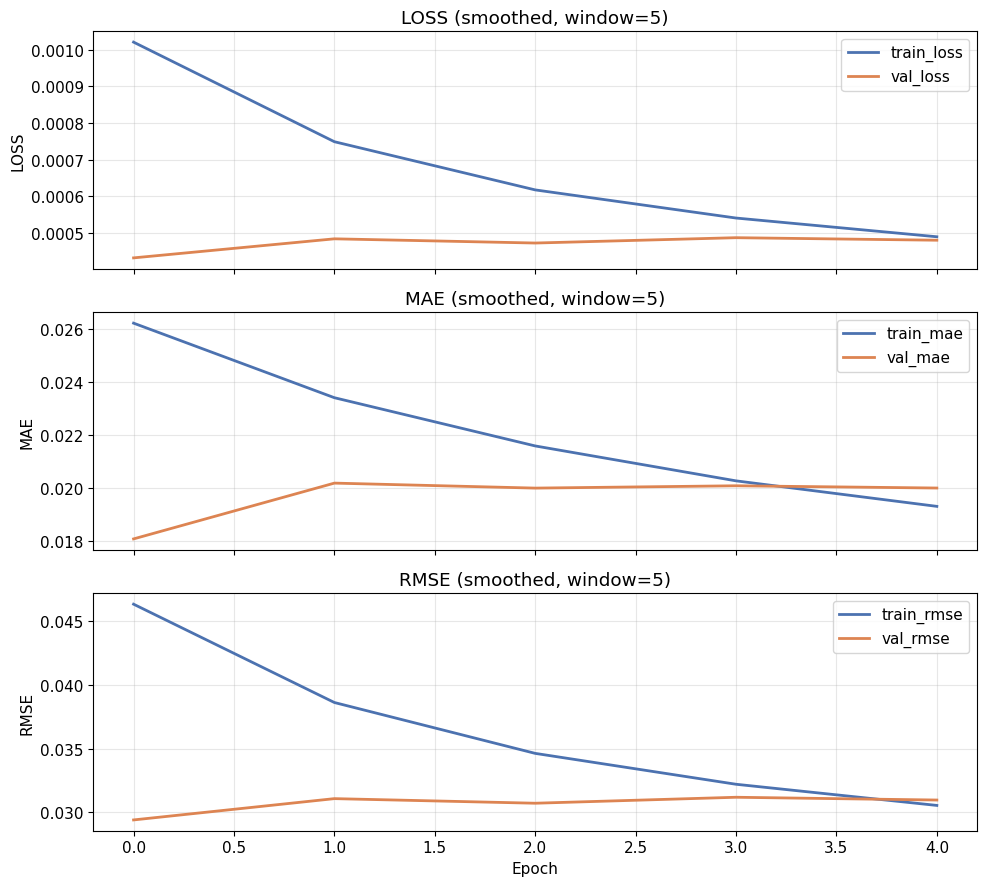

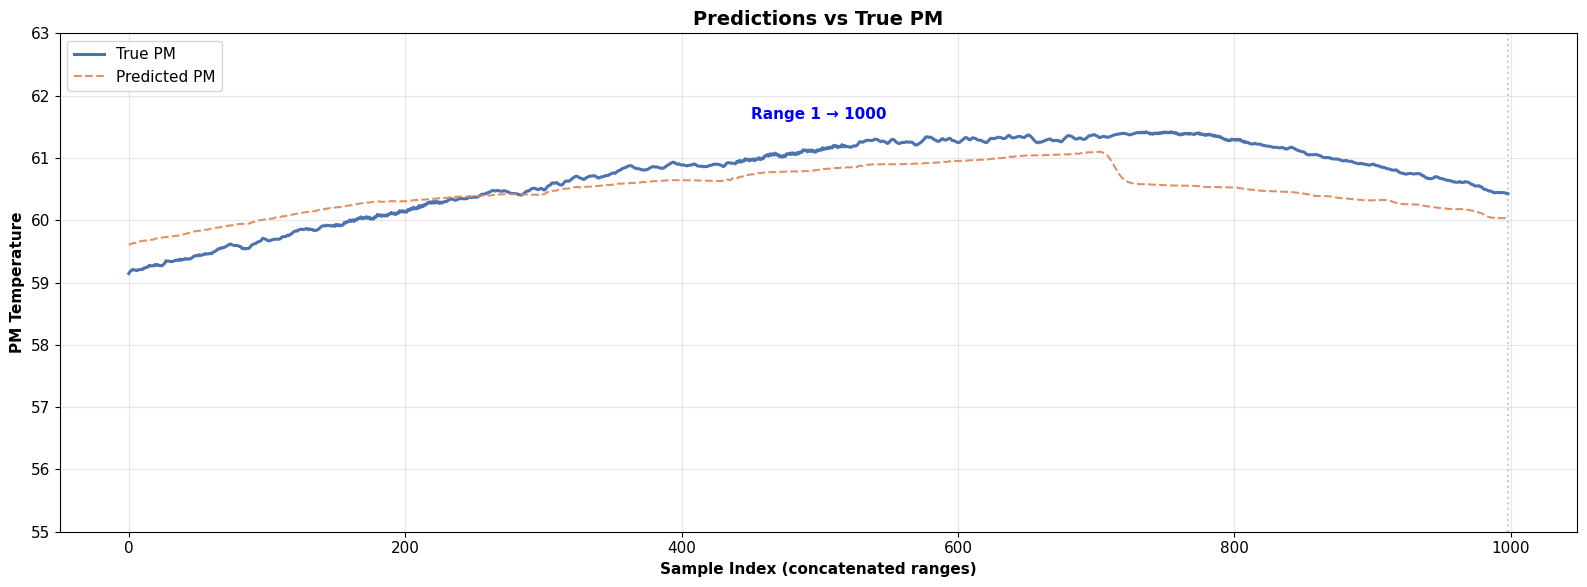

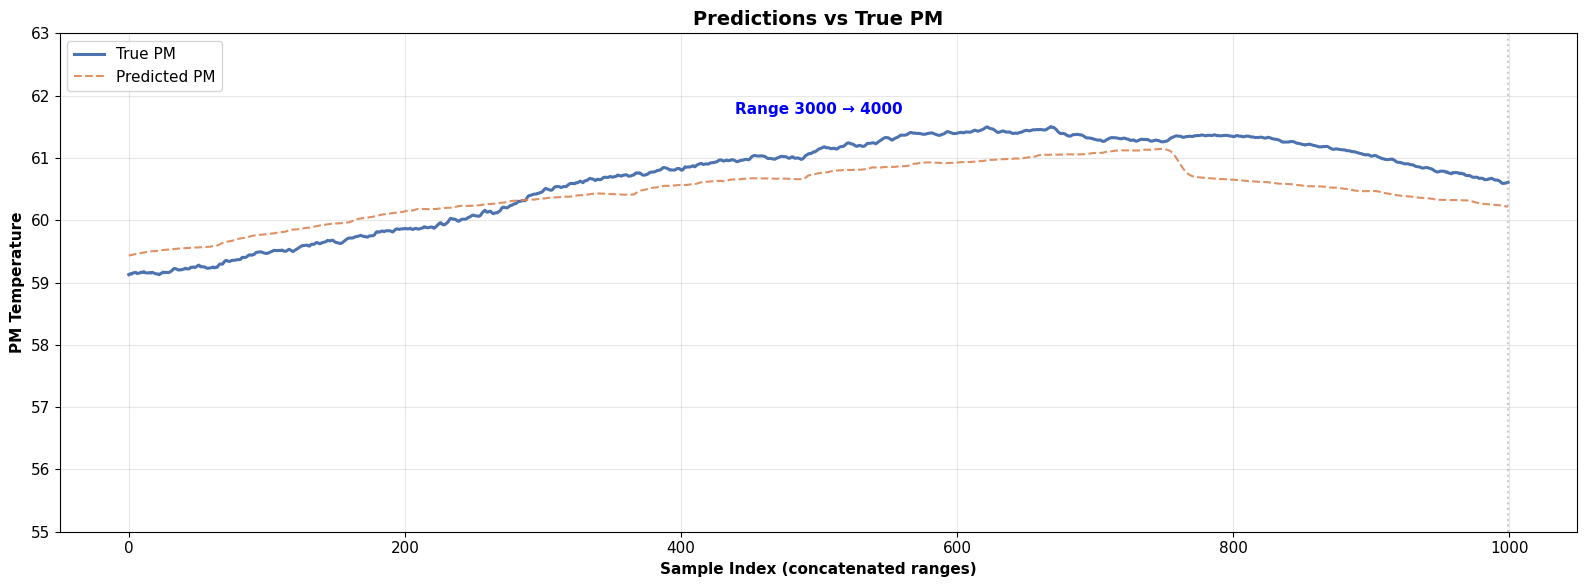

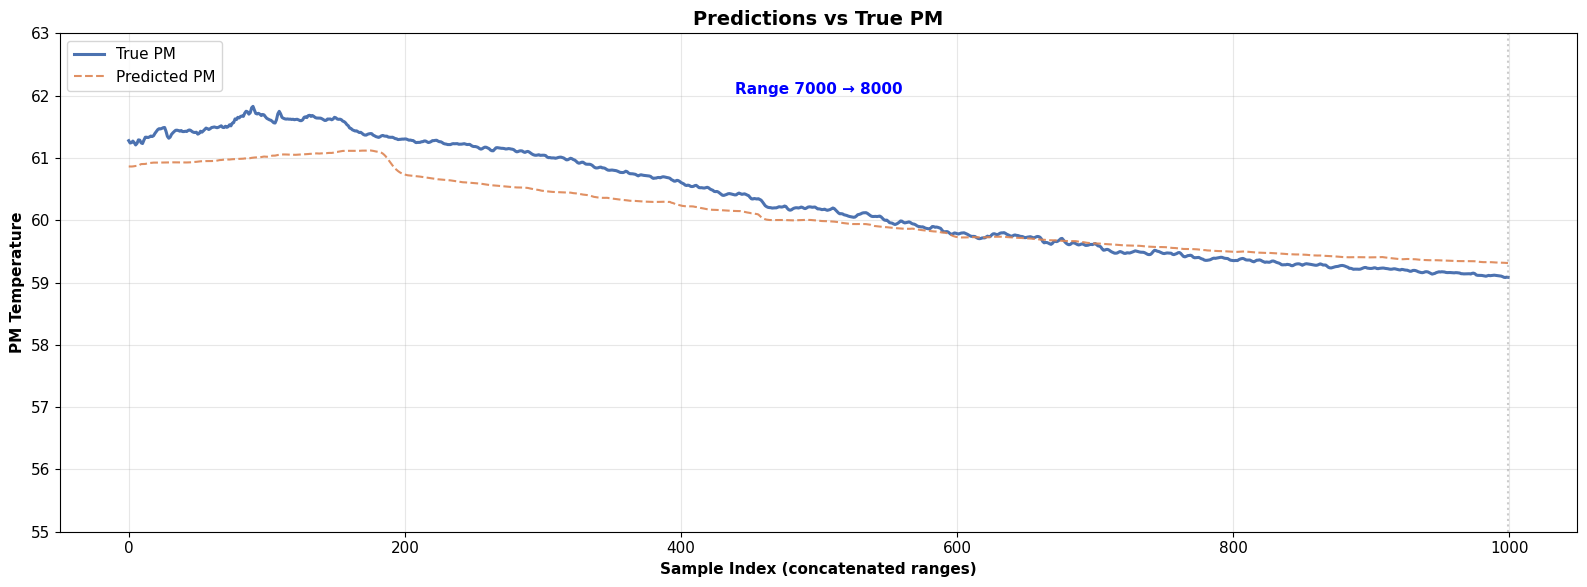

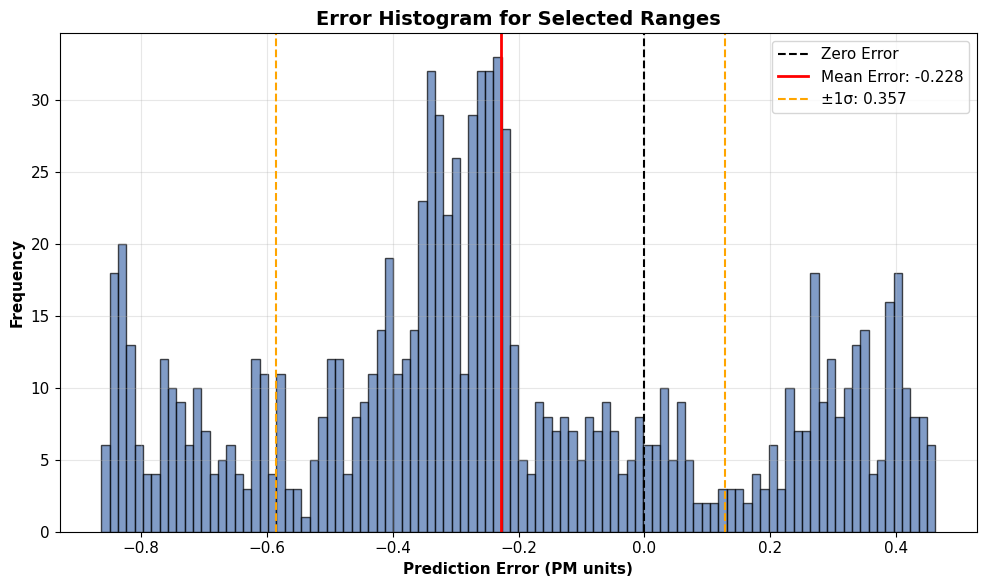

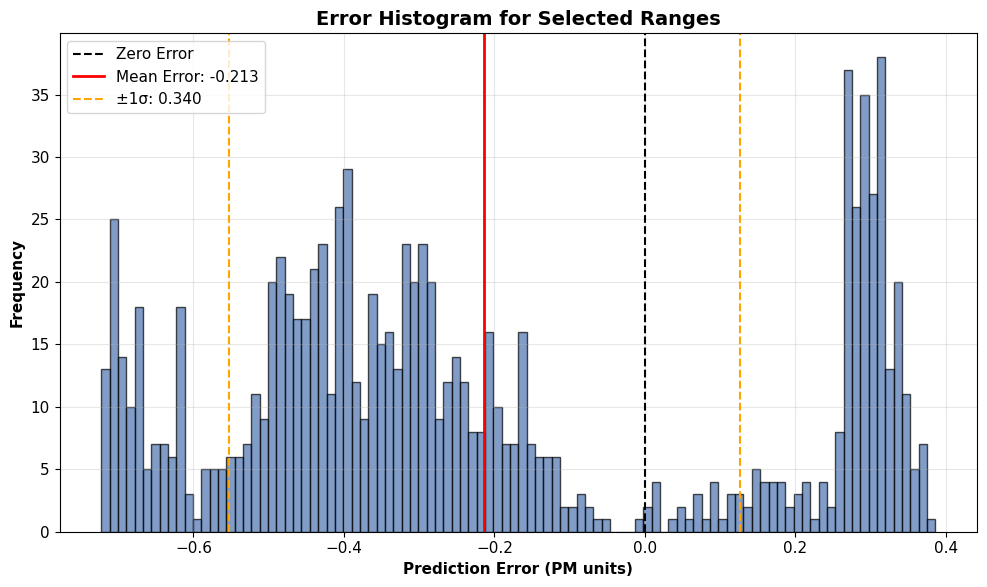

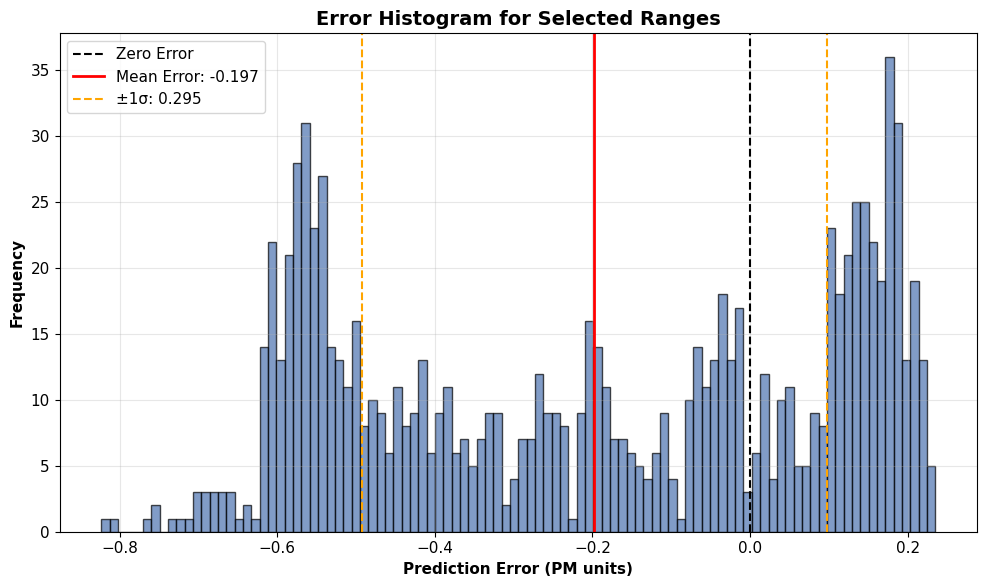

In [170]:
metrics = full_evaluation(model, history, df_results_full)

In [162]:
pm_true = df_results_full['pm_true'].values
pm_pred = df_results_full['pm_pred'].values

mae = mean_absolute_error(pm_true, pm_pred)
rmse = np.sqrt(mean_squared_error(pm_true, pm_pred))

print(f"Test MAE (real PM units): {mae:.4f}")
print(f"Test RMSE (real PM units): {rmse:.4f}")

Test MAE (real PM units): 0.4350
Test RMSE (real PM units): 0.6506


In [147]:
def sample_predictions_across_batches(df_results, samples_per_batch=30):
    n = len(df_results)

    first = df_results.iloc[:samples_per_batch].copy()
    first['section'] = 'first_batch'

    mid_start = n // 2 - samples_per_batch // 2
    middle = df_results.iloc[mid_start:mid_start + samples_per_batch].copy()
    middle['section'] = 'middle_batch'

    last = df_results.iloc[-samples_per_batch:].copy()
    last['section'] = 'last_batch'

    return pd.concat([first, middle, last], ignore_index=True)
sampled_df = sample_predictions_across_batches(df_results_full, 30)
print(sampled_df)


      pm_true    pm_pred      section
0   59.144215  59.612350  first_batch
1   59.144417  59.606853  first_batch
2   59.176460  59.612701  first_batch
3   59.194283  59.624073  first_batch
4   59.212032  59.631271  first_batch
..        ...        ...          ...
85  61.664738  60.963848   last_batch
86  61.705917  60.962822   last_batch
87  61.692898  60.961006   last_batch
88  61.628262  60.960484   last_batch
89  61.625538  60.958858   last_batch

[90 rows x 3 columns]
